<div style="border:solid  orange  2px; padding: 20px">
<H1>Описание проекта</H1>
Интернет-магазину по продаже компьютерных игр обрабатывает исторические данные о продаже игр.<br>
<font color=green>Исходные данные</font>: исторические данные до 2016 год.<br>
<font color=red>Цель</font>: определить показатели успешность игр для выявления потенциально популярных продуктов и планирования рекламных компаний.
</div>

In [1]:
#common imports
import pandas as pd
import re
import matplotlib.pyplot as plt
import requests
import seaborn as sns
from scipy import stats as st

# Шаг 1. Откройте файл с данными и изучите общую информацию

In [2]:
#Загружаем датасет
data=pd.read_csv('datasets/games.csv')

In [3]:
#Взглянем на данные
data.sample(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
7941,Jackie Chan Adventures: Legend of the Dark Hand,GBA,2001.0,Action,0.13,0.05,0.00,0.00,NaN,NaN,NaN
2671,Personal Trainer: Walking,DS,2008.0,Sports,0.21,0.32,0.17,0.07,69.0,tbd,E
15747,Tail of the Sun,PS,1996.0,Role-Playing,0.01,0.01,0.00,0.00,NaN,NaN,NaN
9514,Spider-Man: Battle for New York,DS,2006.0,Platform,0.12,0.00,0.00,0.01,68.0,6.9,E10+
13478,Max & the Magic Marker,DS,2011.0,Platform,0.00,0.04,0.00,0.00,NaN,NaN,NaN


<div style="border:solid  green  2px; padding: 20px">
    <H2>Описание данных</H2>
    - Name — название игры<br>
    - Platform — платформа<br>
    - Year_of_Release — год выпуска<br>
    - Genre — жанр игры<br>
    - NA_sales — продажи в Северной Америке (миллионы долларов)<br>
    - EU_sales — продажи в Европе (миллионы долларов)<br>
    - JP_sales — продажи в Японии (миллионы долларов)<br>
    - Other_sales — продажи в других странах (миллионы долларов)<br>
    - Critic_Score — оценка критиков (максимум 100)<br>
    - User_Score — оценка пользователей (максимум 10)<br>
    - Rating — рейтинг от организации ESRB<br>
</div>

In [5]:
#Посмотрим на распределение столбцов, в которых содержатся только числа
data.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


In [6]:
#Посмотрим на структуру таблицы
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**Вывод**: исходный набор данных представляет собой двумерную таблицу, размером  (16715, 11). Первончальный анализ данных показывает, что больше всего пропусков в столбцах, связанных с рейтингом. Возможно, основная причина в том, что рейтинги для самых свежих игр (за 2016 год) ещё не успели сформироваться, а для старых игр некому было их формировать. К тому же столбцы с количеством проданных копий содержат слишком много нулевых значений, настолько много, что 25% и 50% квантили равны 0 для некоторых столбцов.

# Шаг 2. Подготовьте данные

In [7]:
#Приводим названия столбцов к нижнему регистру
data.columns=data.columns.str.lower()
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [8]:
#Посмотрим какие платформы используются при анализе
#len(data['name'].unique())/len(data)
data['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [9]:
#Посмотрим какие существуют рейтинги
data['rating'].unique()
#EC - early childhood
#E - everyone
#E10+ - everyone 10 and older
#T - teen
#M-Mature
#AO - adults only 18+
#RP - reiting pending

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [10]:
#Взглянем на игры без имени
data[data['name'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [11]:
#У двух игр отсутсвует наименование, дропним их
#data[data['name'].isnull()]
data.dropna(subset=['name'], inplace=True)
#Скинем индексы
data.reset_index(drop=True,inplace=True)

In [12]:
#Удастоверимся что датафрейм уменьшился только на 2 строки
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [13]:
#У 269 игр нет года реализации. Взгляним на них
data[data['year_of_release'].isnull()]
#data[data['year_of_release'].isnull() & ~data['name'].str.isalpha()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16371,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+
16403,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16446,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16456,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [14]:
#Поспользуемся регулярными выражениями чтобы заполнить год реализации
def set_year(row):
    if pd.isnull(row['year_of_release']):
        #temp=find_year.findall(row['name'])
        temp=find_year.search(row['name'])
        if temp!=None:
            result_group=temp.group()
            try:
                return(int(result_group)-1)
            except:
                #Наименования могут содержать формат 20-10
                if '-' in result_group:
                    return(2000+int(result_group.split('-')[1])-1)
                #Или 20К02
                if 'K' in result_group:
                    return(2000+int(result_group.split('K')[1])-1)
    return row['year_of_release']

In [15]:
#Регулярное выражение для поиска даты выпуска игры
find_year=re.compile(r'(\d\d(-)?\d\d)|(\dK\d)')
data['year_of_release']=data.apply(set_year, axis=1)

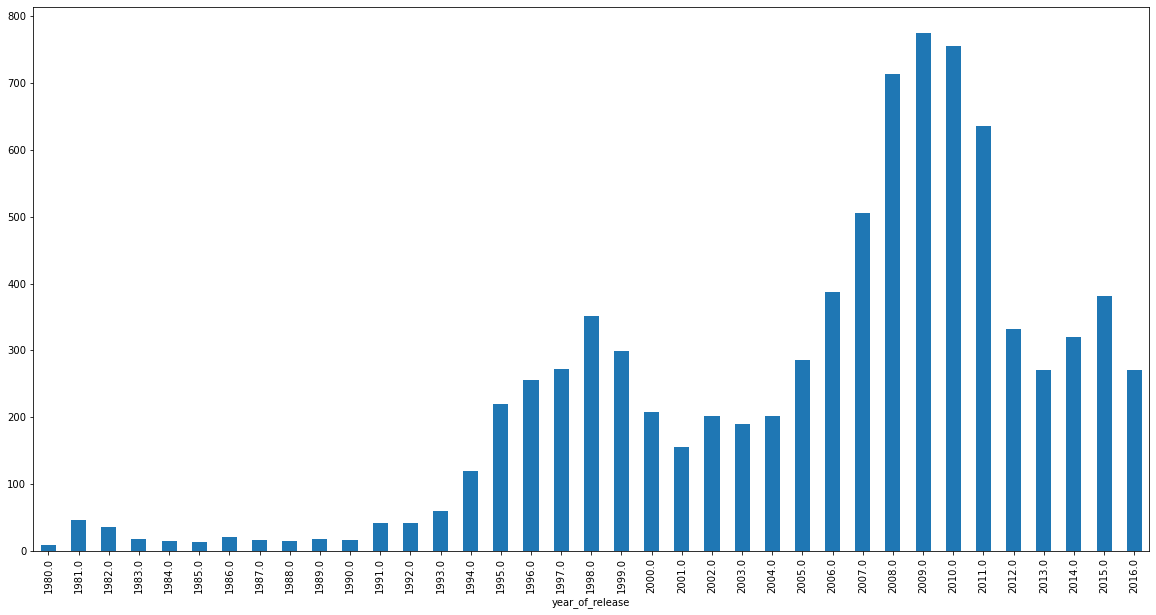

In [16]:
#Количество игр с пропущенными оценками по годам
data[data['critic_score'].isnull()].groupby('year_of_release').count()['name'].plot(kind='bar', figsize=(20,10))
plt.savefig('test', format='png', dpi=300)

In [17]:
#Заменим tbd (to be determined) на -2
data.loc[data['user_score']=='tbd','user_score']=-2
#приведём к целым числам
data['user_score']=data['user_score'].astype('float')

In [18]:
#Некоторые игры выпускались на различные платформы в один год (или в соседний), 
#поэтому сгруппируем релевантные данные по имени и заполним пропуски 
grouped_data_by_name=data.pivot_table(index='name', aggfunc=['median'])#, values=['year_of_release', 'na_sales', ])
grouped_data_by_name

median                             \
                             critic_score eu_sales jp_sales na_sales   
name                                                                   
 Beyblade Burst                       NaN    0.000     0.03    0.000   
 Fire Emblem Fates                    NaN    0.230     0.52    0.810   
 Frozen: Olaf's Quest                 NaN    0.265     0.00    0.240   
 Haikyu!! Cross Team Match!           NaN    0.000     0.04    0.000   
 Tales of Xillia 2                   71.0    0.120     0.45    0.200   
...                                   ...      ...      ...      ...   
thinkSMART: Chess for Kids            NaN    0.000     0.00    0.010   
uDraw Studio                         71.0    0.570     0.00    1.650   
uDraw Studio: Instant Artist         54.0    0.050     0.00    0.035   
wwe Smackdown vs. Raw 2006            NaN    1.020     0.00    1.570   
¡Shin Chan Flipa en colores!          NaN    0.000     0.14    0.000   

                                                                     
                             other_sales user_score year_of_release  
name                                                                 
 Beyblade Burst                    0.000        NaN          2016.0  
 Fire Emblem Fates                 0.110        NaN          2015.0  
 Frozen: Olaf's Quest              0.045        NaN          2013.0  
 Haikyu!! Cross Team Match!        0.000        NaN          2016.0  
 Tales of Xillia 2                 0.070       7.90          2012.0  
...                                  ...        ...             ...  
thinkSMART: Chess for Kids         0.000      -2.00          2011.0  
uDraw Studio                       0.200      -2.00          2010.0  
uDraw Studio: Instant Artist       0.010       1.85          2011.0  
wwe Smackdown vs. Raw 2006         0.410        NaN          2005.0  
¡Shin Chan Flipa en colores!       0.000        NaN          2007.0  

[11559 rows x 7 columns]

In [19]:
grouped_data_by_name.set_axis(['critic_score', 'eu_sales', 
                               'jp_sales', 'na_sales', 'other_sales', 'user_score','year_of_release'], axis=1, inplace=True)
data_filled=pd.merge(data,grouped_data_by_name, left_on='name', right_index=True, how='left', suffixes=("", '_grouped'))
data_filled[data_filled['year_of_release'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,critic_score_grouped,eu_sales_grouped,jp_sales_grouped,na_sales_grouped,other_sales_grouped,user_score_grouped,year_of_release_grouped
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+,75.0,0.440,0.00,0.720,0.290,7.90,2008.0
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN,NaN,0.030,0.00,0.105,0.000,NaN,1999.0
627,Rock Band,X360,NaN,Misc,1.93,0.33,0.00,0.21,92.0,8.2,T,87.0,0.370,0.00,1.160,0.215,7.50,NaN
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,2.15,0.18,0.00,0.07,73.0,-2.0,E,73.0,0.180,0.00,2.150,0.070,-2.00,NaN
677,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,1.51,0.61,0.00,0.21,78.0,6.6,E10+,77.0,0.480,0.00,0.600,0.210,7.70,2008.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16346,Agarest Senki: Re-appearance,PS3,NaN,Role-Playing,0.00,0.00,0.01,0.00,NaN,NaN,NaN,NaN,0.000,0.01,0.000,0.000,NaN,NaN
16403,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T,66.0,0.010,0.00,0.020,0.000,-2.00,2003.0
16446,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M,56.0,0.020,0.00,0.030,0.010,6.50,2012.0
16456,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN,NaN,0.000,0.00,0.010,0.000,NaN,NaN


In [20]:
def set_another_years(row):
    if pd.isnull(row['year_of_release']):
        return row['year_of_release_grouped']
    return row['year_of_release']

In [21]:
data_filled['year_of_release']=data_filled.apply(set_another_years, axis=1)

In [22]:
data_filled['year_of_release'].fillna(1970, inplace=True)

In [23]:
#Удалим использованный столбец
del data_filled['year_of_release_grouped']

In [24]:
data_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  16713 non-null  object 
 1   platform              16713 non-null  object 
 2   year_of_release       16713 non-null  float64
 3   genre                 16713 non-null  object 
 4   na_sales              16713 non-null  float64
 5   eu_sales              16713 non-null  float64
 6   jp_sales              16713 non-null  float64
 7   other_sales           16713 non-null  float64
 8   critic_score          8137 non-null   float64
 9   user_score            10014 non-null  float64
 10  rating                9949 non-null   object 
 11  critic_score_grouped  9098 non-null   float64
 12  eu_sales_grouped      16713 non-null  float64
 13  jp_sales_grouped      16713 non-null  float64
 14  na_sales_grouped      16713 non-null  float64
 15  other_sales_grouped

In [25]:
def set_critic_score(row):
    if pd.isnull(row['critic_score']):
        return row['critic_score_grouped']
    return row['critic_score']
def set_user_score(row):
    if pd.isnull(row['user_score']):
        return row['user_score_grouped']
    return row['user_score']

In [26]:
#Аналогичные действия проделаем и для оценок
data_filled['critic_score']=data_filled.apply(set_critic_score, axis=1)
data_filled['user_score']=data_filled.apply(set_user_score, axis=1)
data_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  16713 non-null  object 
 1   platform              16713 non-null  object 
 2   year_of_release       16713 non-null  float64
 3   genre                 16713 non-null  object 
 4   na_sales              16713 non-null  float64
 5   eu_sales              16713 non-null  float64
 6   jp_sales              16713 non-null  float64
 7   other_sales           16713 non-null  float64
 8   critic_score          9098 non-null   float64
 9   user_score            10443 non-null  float64
 10  rating                9949 non-null   object 
 11  critic_score_grouped  9098 non-null   float64
 12  eu_sales_grouped      16713 non-null  float64
 13  jp_sales_grouped      16713 non-null  float64
 14  na_sales_grouped      16713 non-null  float64
 15  other_sales_grouped

In [27]:
#Пустые значения изменим на -1
data_filled['user_score'].fillna(-1, inplace=True)
data_filled['critic_score'].fillna(-1, inplace=True)

In [28]:
#Дропнем лишние столбцы 
del data_filled['critic_score_grouped']
del data_filled['eu_sales_grouped']
del data_filled['jp_sales_grouped']
del data_filled['na_sales_grouped']
del data_filled['other_sales_grouped']
del data_filled['user_score_grouped']

In [29]:
#Преобразуйте данные в нужные типы.
data_filled['year_of_release']=data_filled['year_of_release'].astype('int')
data_filled

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1.0,-1.0,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1.0,-1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16708,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,-1.0,-1.0,NaN
16709,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,-1.0,-1.0,NaN
16710,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,-1.0,-1.0,NaN
16711,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,-1.0,-1.0,NaN


In [30]:
#Посмотрим, как с годами изменялось соотношение между играми с обзорами и без них
for_analysis=data_filled.groupby('year_of_release').count()['name']
for_analysis=for_analysis.reset_index()

In [31]:
data_with_absence=data_filled.query('critic_score==-1.0 or user_score==-1.0 or user_score==-2').groupby('year_of_release').count()['name']
data_with_absence=data_with_absence.reset_index()

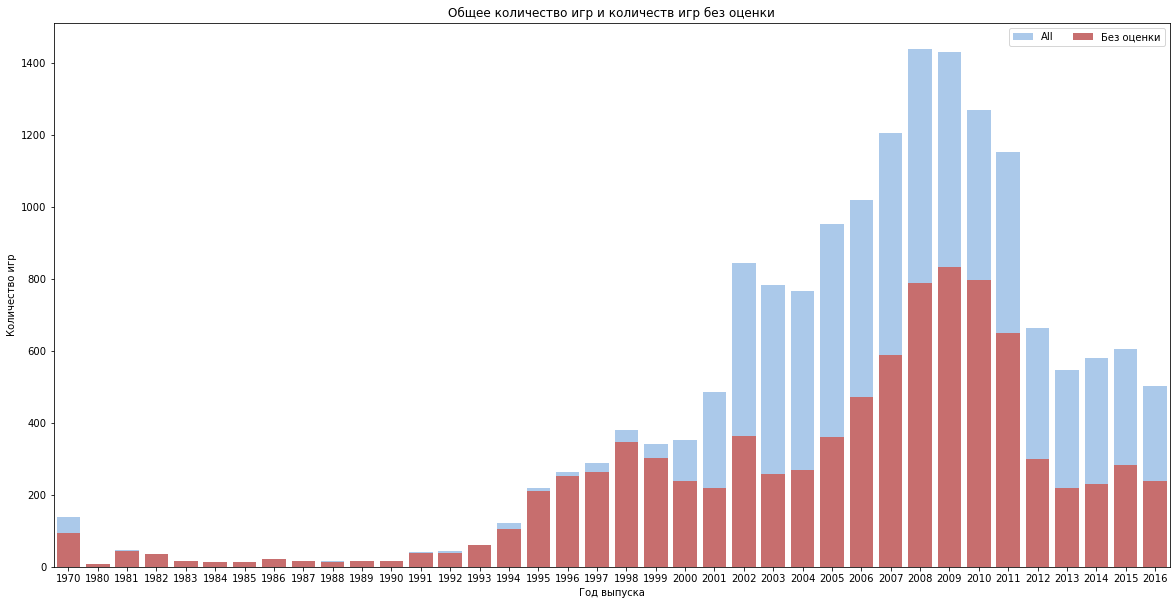

In [32]:
f,ax=plt.subplots(figsize=(20,10))

sns.set_color_codes('pastel')
sns.barplot(x='year_of_release', y='name', data=for_analysis,
           label='All', color='b').set_title('Общее количество игр и количеств игр без оценки')

sns.set_color_codes("muted")
sns.barplot(x="year_of_release", y="name", data=data_with_absence,
            label="Без оценки", color="r")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="best", frameon=True)
ax.set(ylabel='Количество игр',
       xlabel="Год выпуска")

plt.show()

**Вывод**: 
первым этапом было необходимос определить наличие повторений в наименованиях игр. С помощью метода unique было обнаружено, что существует только 11560 уникальных наименования игр, что соответветствует 69% исходного набора. Следовательно, остальные 31% - это повторы. Повторы обусловлены тем, что игра выходит на разные платформы

Работа с пропусками:
- name - 2 пропоска - так как это игры от 1993 года, общее количество проданных копий не велико (2.39 и 0.03) и столбцы с жанром и отзывами пустые, их можно дропнуть. Возможная причина появления этой ошибки - специфичные для платформы игры (1993 год), о которых почти ничего не известно, но на момент обращения к сайту с информацией об играх на сайте была запись только о продажах некоторых игр без имени или это наборы игр (99 игр в одном).
- year_of_release - 269 пропусков - 21 запись можно заполнить следующим образом, в названии игры указан год её выпуска+1. Также у некоторых игр, выпущенных на разные платформы, отсутствуют значения в данном столбце. Их можно заполнить медианами по сгруппированным по названиям играм (+109 заполнных строк). Остальные записи заполним 1970 годом, чтобы их можно было потом использовать для анализа, но при этом они не портили картину.
- critic_score и user_score - тоже попытаемся заполнить медианными значениями (удалось востановить 961 и 429 пропущенных значения соответственно). В остальных установим -1. В столбце user_score были значения tbd их мы заменили на -2 (to be determined)
Основная причина пропусков в столбцах - это ошибка в работе парсера интернет страниц. Возможно, доступ к странице с информацией об игре имеет следующий формат: url_сайта/тип_платформы/имя_игры. Но в наименовании игры также могла быть информация об платформе, для которой выпускалась игра, и соответственно доступ по автоматически сгенерированному url получал ошибку 404, потому что следовало искапть по игре, например, Minecraft: Switch edition, а не просто Minecraft. Также url мог выбрасывать некоторые символы (например, знак имперсанта) или заменить их на аналогичные, например вместо black ops 3 использовать black-ops-iii.
Также существует ещё одна проблема в данных. Для старых игр очень часто отсутствуют отзывы и оценки. Возможно сайт начал работу с в более поздний период, чем начали появляться игры и, как следствие, отзывы не успевали для старых игр, которые к моменту появления сайта уже исчезли из продаж (может даже консоли для этих игр исчезли к этому году). Также из графика видно, что в 2002 произошёл бурный рост в компьютерных играх (прирост почти в 2 раза), но при этом у людей появились консоли и пк и они захотели поделиться своим мнением об играх (об этом свидетельствует уменьшение количества игр без отзывов с 98 по 2001 годы, но потом игровая индустрия выпускает всё больеш игр, всё больше консолей и игр, у которых  нет отзывов становится всё больше, а потом приходит новое поколение консолей объём ежегодно выпускаемых игр уменьшается, и, как следствие, появляется меньше пропусков в оценках игр. 

следующие столбцы требовали предпрозования типов:
- year_of_release - приводить к данным типа Datetime нет необходимости, так как там храняться только только года. Поэтому просто отбросим нуль путём приведения к целочисленным значениям

# Шаг 3. Проведите исследовательский анализ данных

In [33]:
for_analysis.set_index("year_of_release", inplace=True)
#Проссумируем все продажи в отдельный столбец
data_filled['all_sales']=data_filled['na_sales']+data_filled['eu_sales']+data_filled['jp_sales']+data_filled['other_sales']

In [34]:
#Сгруппируем данные по годам
grouped_by_year=data_filled.pivot_table(index='year_of_release', values='all_sales', aggfunc='sum')

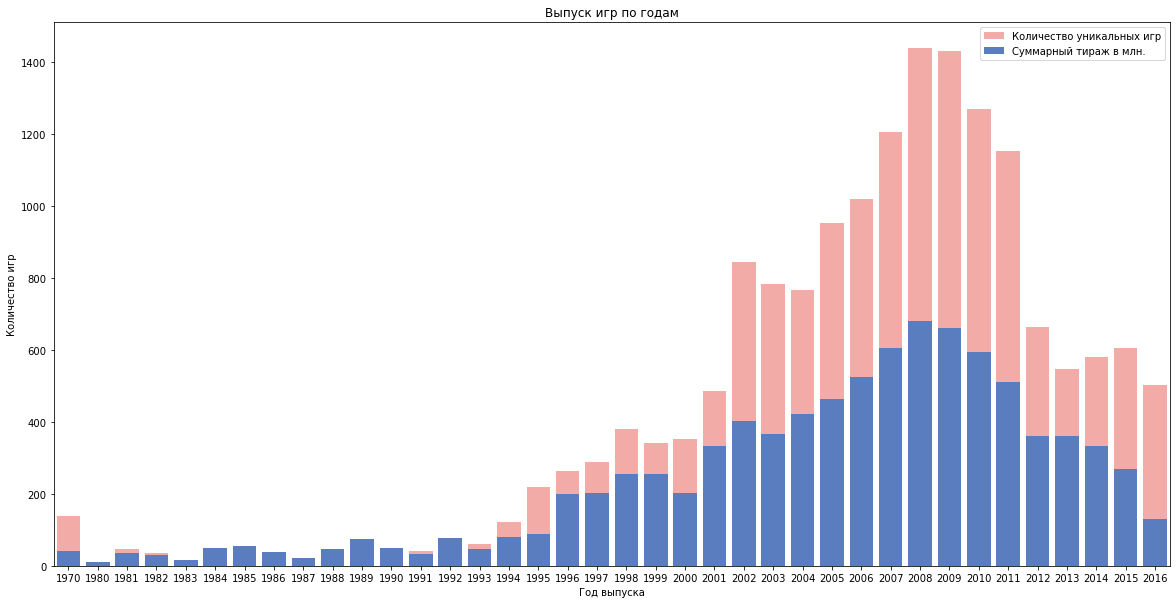

In [35]:
#Суммарные объёмы продаж
f,ax=plt.subplots(figsize=(20,10))

sns.set_color_codes('pastel')
sns.barplot(x=for_analysis.index, y='name', data=for_analysis,
           label='Количество уникальных игр', color='r')

sns.set_color_codes("muted")
sns.barplot(x=grouped_by_year.index,y='all_sales',label='Суммарный тираж в млн.', data=grouped_by_year, color='b')

ax.legend(loc="best", frameon=True)

ax.set(ylabel='Количество игр',
       xlabel="Год выпуска",
      title='Выпуск игр по годам')

plt.show()

In [36]:
#Сгруппируем данные по платформам
groudep_by_platform=data_filled.pivot_table(index=['platform'], values='all_sales', aggfunc='sum')
#popular_platform=groudep_by_platform.sort_values(by='all_sales').query('all_sales>50').index
popular_platform=groudep_by_platform.sort_values(by='all_sales').iloc[-20:].index
popular_platform

Index(['WiiU', '2600', 'XOne', 'GC', 'SNES', 'N64', 'NES', 'GB', 'XB', '3DS',
       'PC', 'PSP', 'PS4', 'GBA', 'PS', 'DS', 'Wii', 'PS3', 'X360', 'PS2'],
      dtype='object', name='platform')

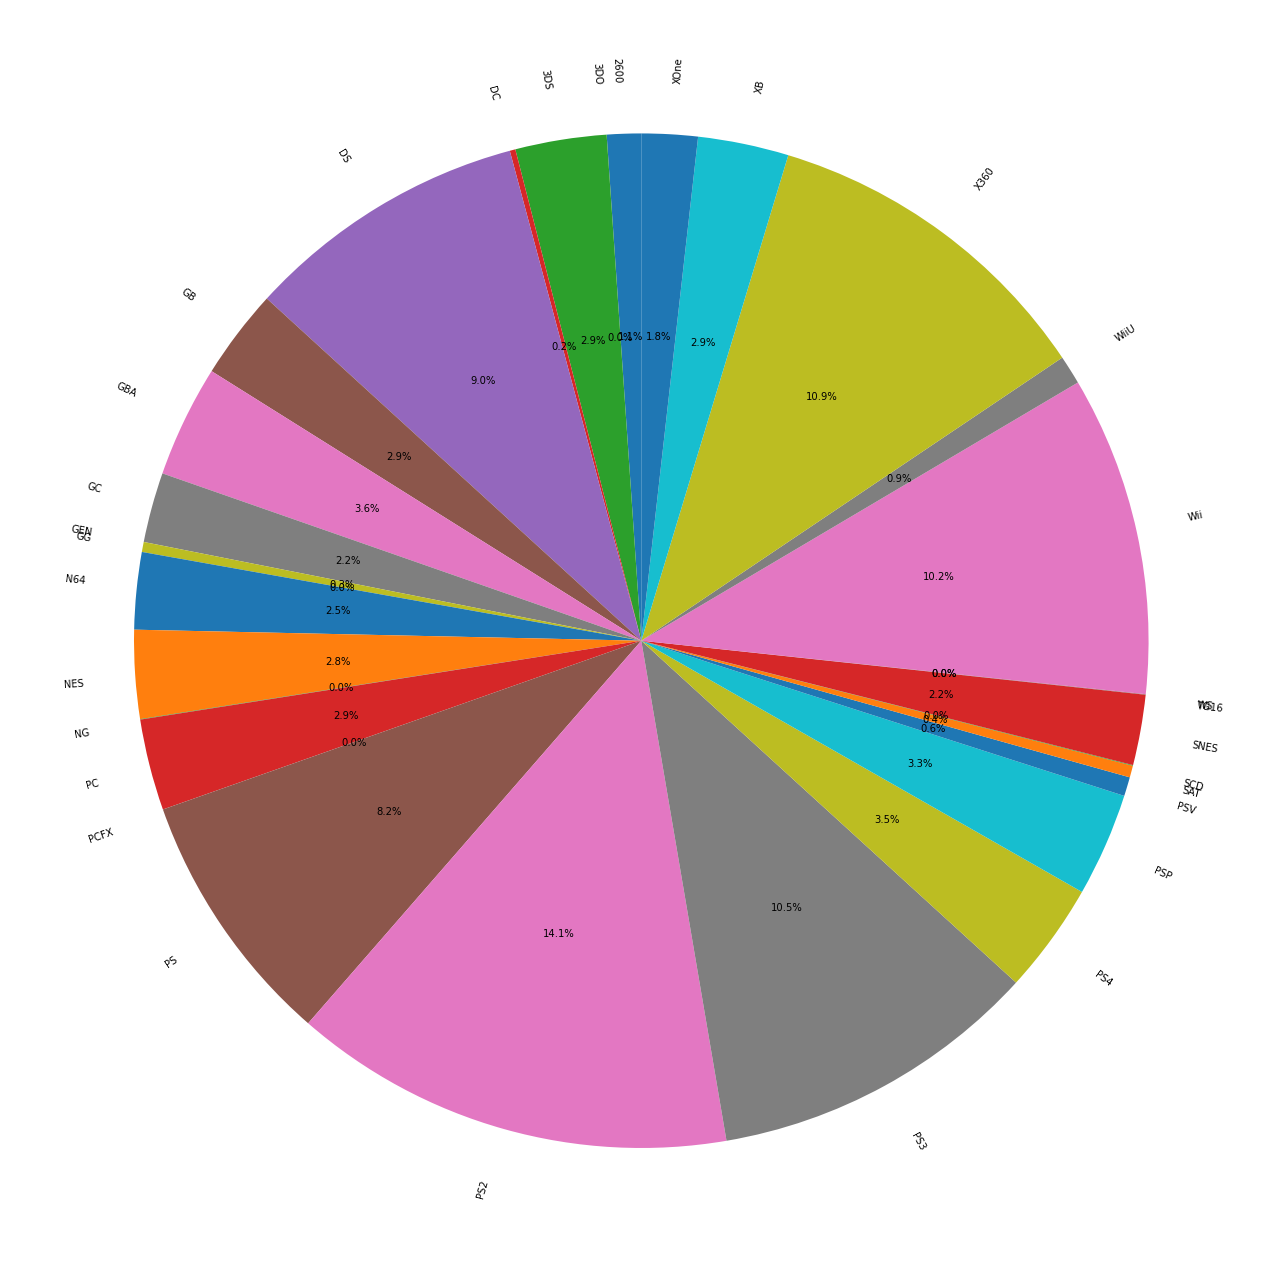

In [37]:
#Круговая диаграмма по платформам
plt.figure(figsize=(50,50))
plt.subplot(121)
plt.pie(
    groudep_by_platform['all_sales'],
    # with the labels being platform
    labels=groudep_by_platform.index,
    #shadow=True, 
    autopct='%1.1f%%',
    startangle=90,
    rotatelabels=True,
    )
#plt.axis('equal')
#plt.title('Pie Chart of 8th Gen Global Sales')
plt.show()

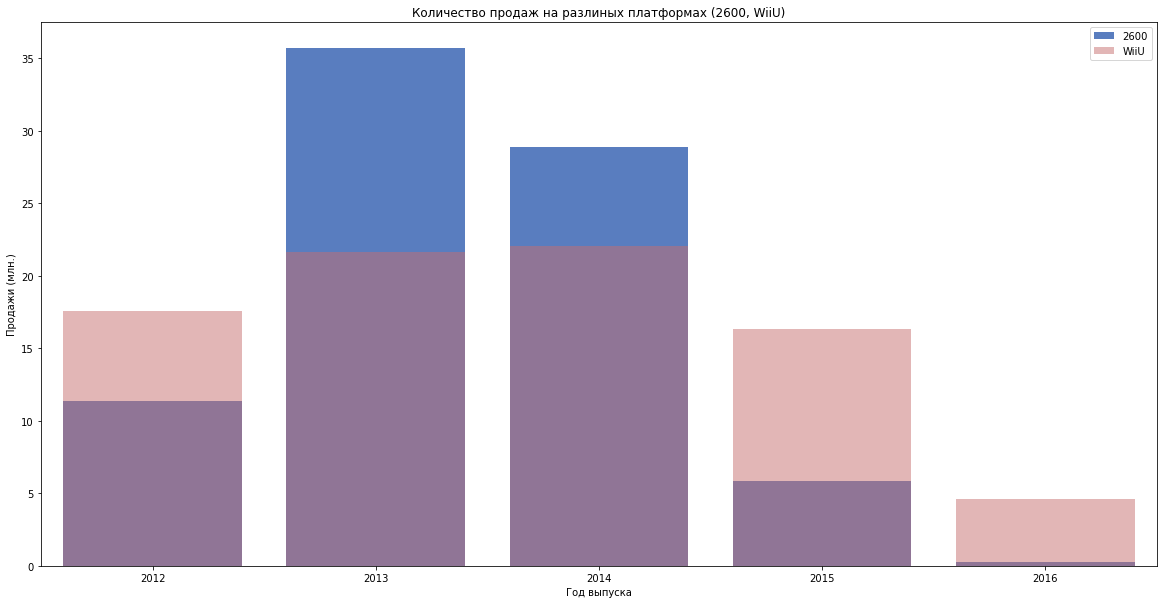

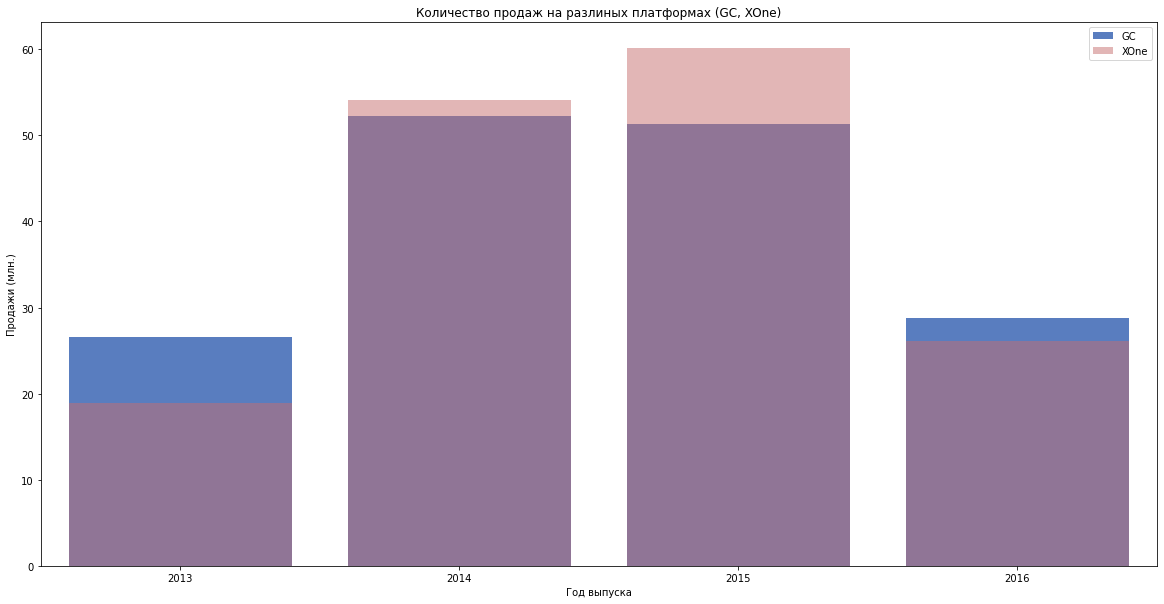

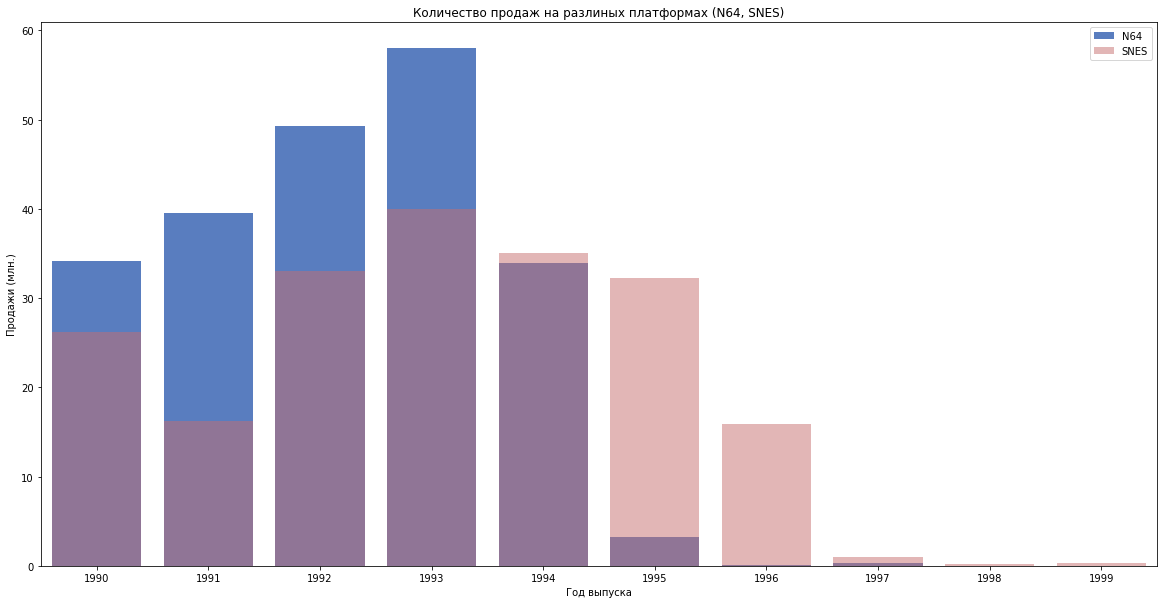

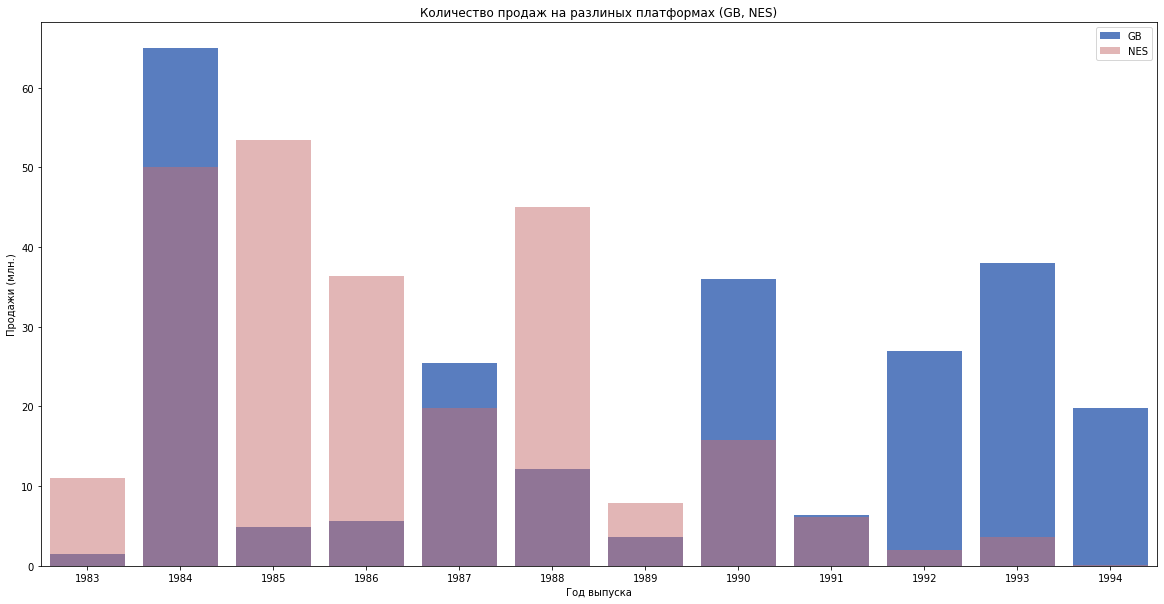

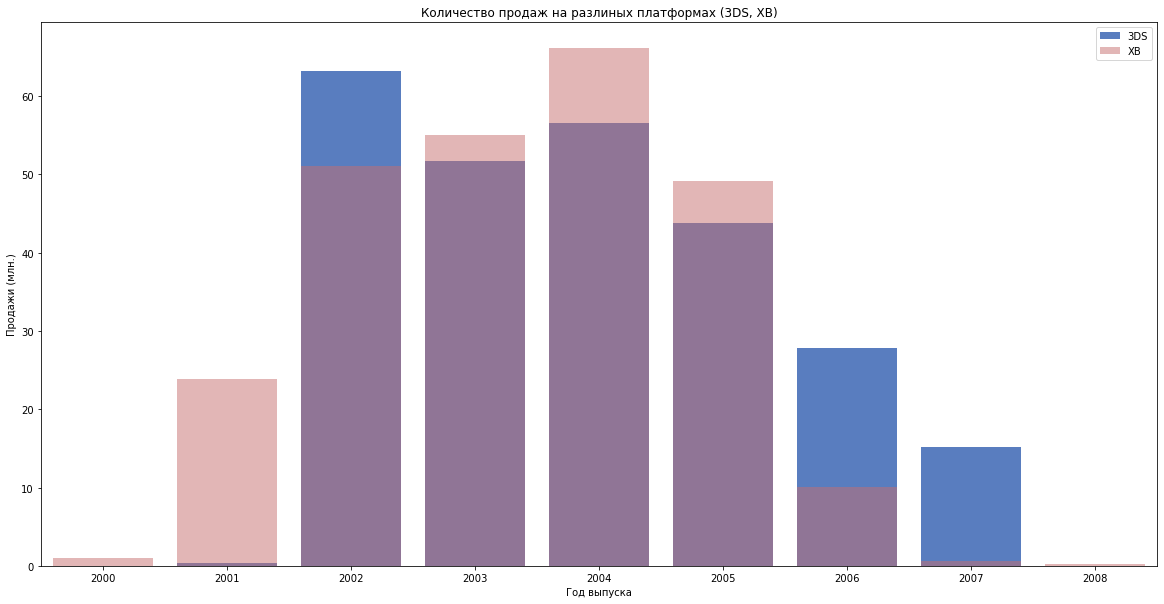

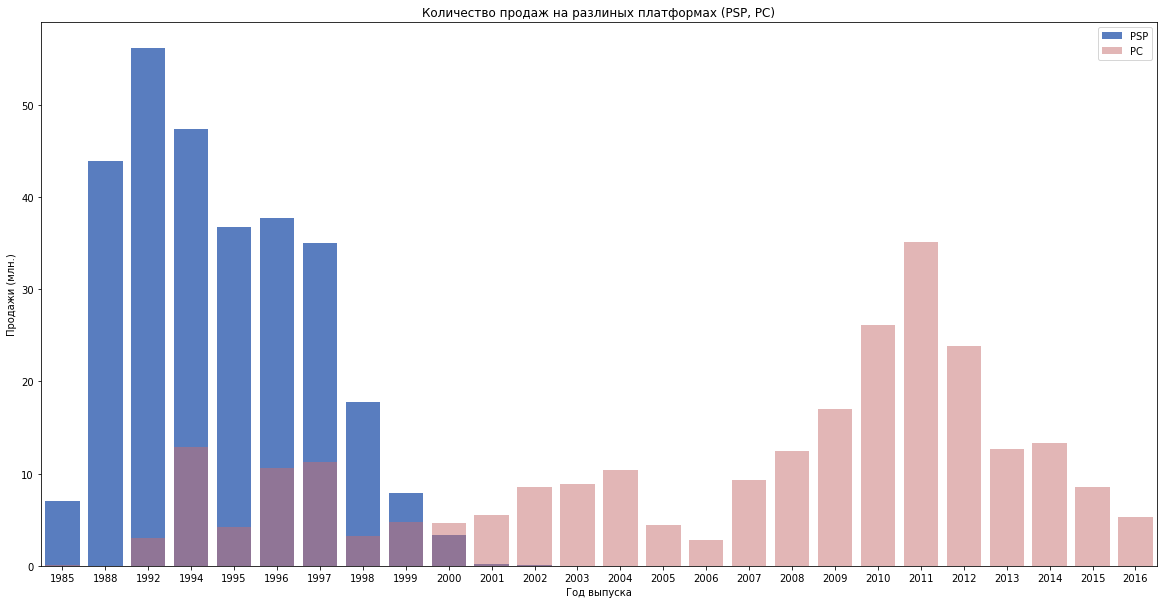

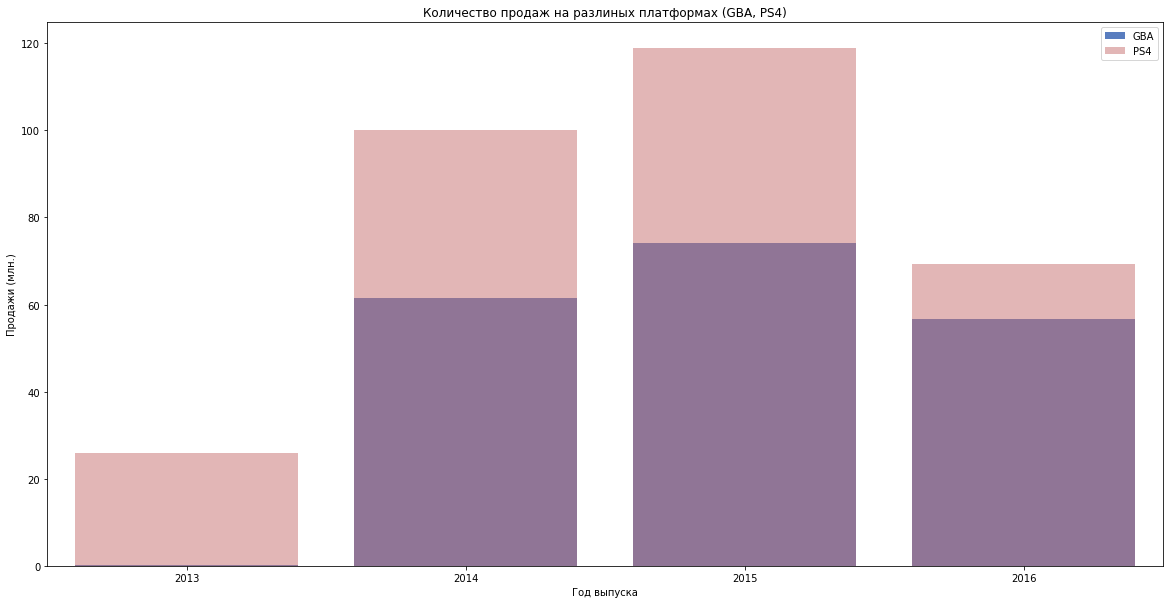

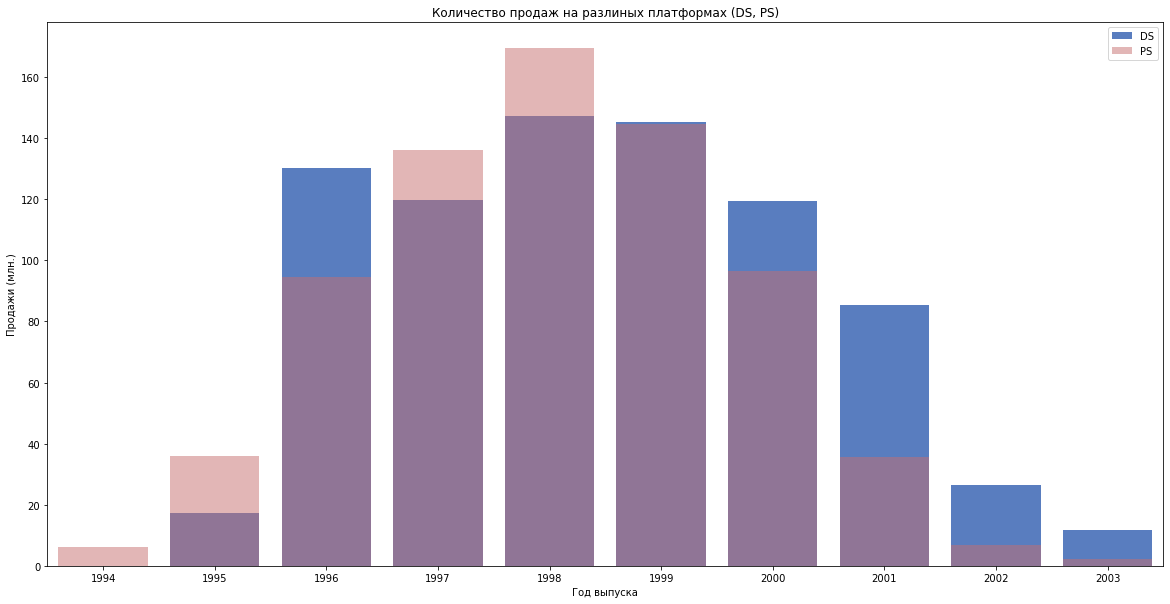

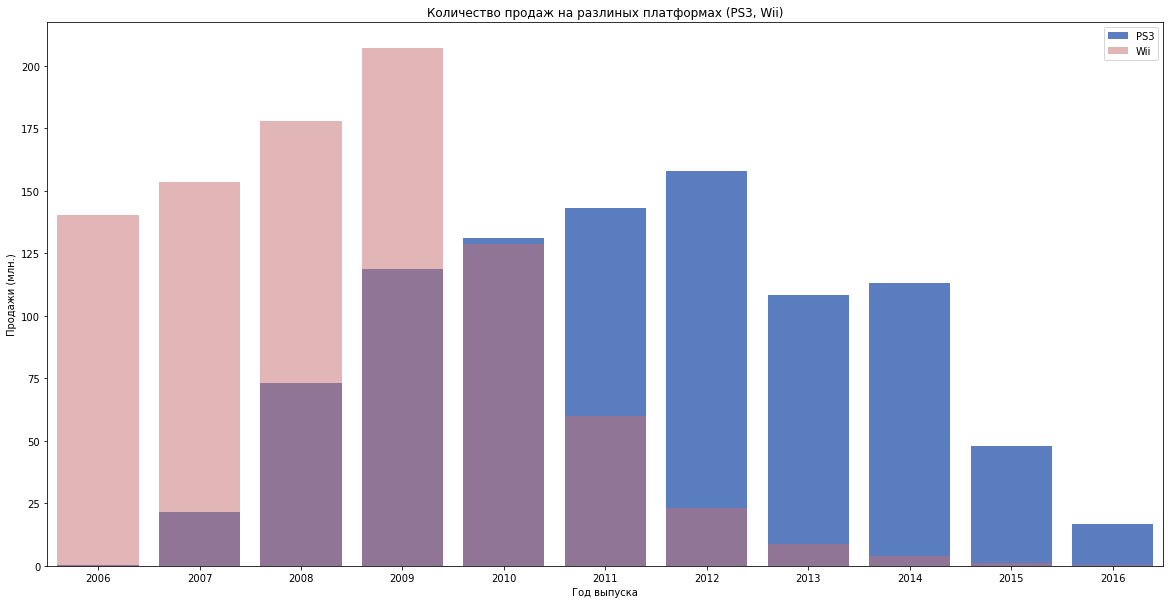

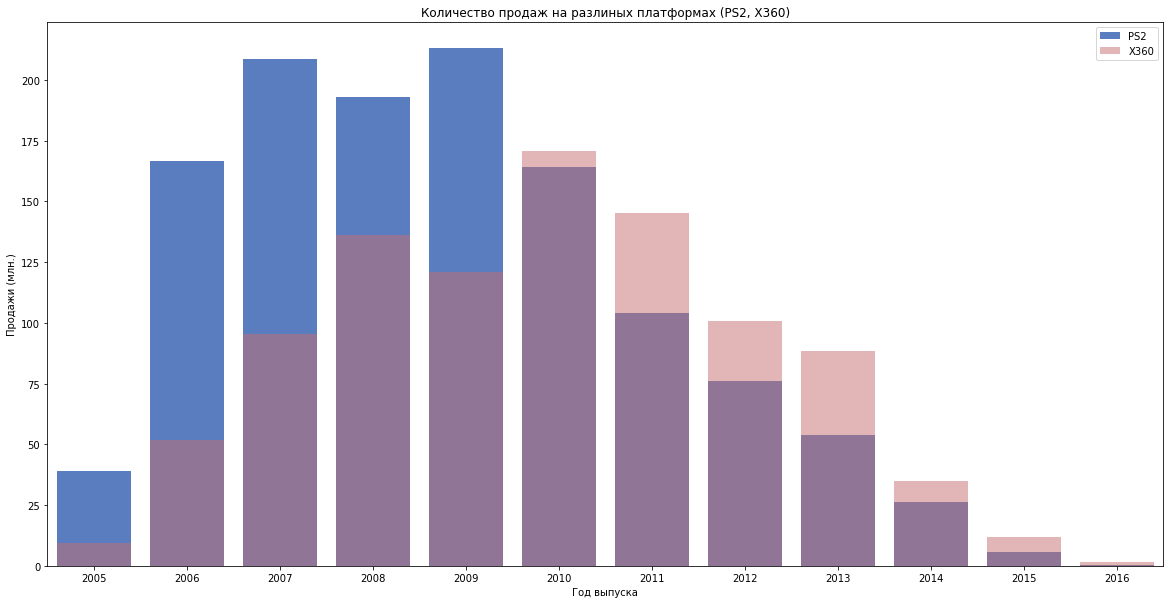

In [38]:
#Посмотрим как менялись продажи наиболее популярных (топ-20) платформ по годам
grouped_by_popular_platform=data_filled.query('platform in @popular_platform').pivot_table(index=['platform','year_of_release'], 
                                                                                           values='all_sales',
                                                                                          aggfunc='sum')
grouped_by_popular_platform.reset_index(inplace=True)

platform_life={}

for i in range(0,len(popular_platform),2):
    f,ax=plt.subplots(figsize=(20,10))
    platform=popular_platform[i+1]
    data_local=grouped_by_popular_platform.query('platform==@platform and year_of_release>1970')
    sns.barplot(x='year_of_release', y='all_sales', data=data_local, 
                label=platform, color='b')
    platform_life[platform]=3*data_local['year_of_release'].std()
    
    platform=popular_platform[i]
    data_local=grouped_by_popular_platform.query('platform==@platform and year_of_release>1970')
    sns.barplot(x='year_of_release', y='all_sales', data=data_local, 
                label=platform, color='r', alpha=0.5)
    platform_life[platform]=3*data_local['year_of_release'].std()
    
    ax.legend(loc="best", frameon=True)
    
    ax.set(ylabel='Продажи (млн.)',
       xlabel="Год выпуска",
      title='Количество продаж на разлиных платформах ('+ popular_platform[i+1]+", "+popular_platform[i]+')')
    
    plt.show()

In [39]:
#По медиане узнаем медианное время жизни консоли
platform_life_df=pd.DataFrame(index=platform_life.keys(), data=platform_life.values(), columns=['age'])
platform_life_df['age'].median()

10.383264098729082

In [40]:
#Время жизни каждой популярной платформы
platform_life_df.T

,2600,WiiU,GC,XOne,N64,SNES,GB,NES,3DS,XB,PSP,PC,GBA,PS4,DS,PS,PS3,Wii,PS2,X360
age,15.693079,4.743416,6.480741,3.872983,8.007809,9.082951,12.992601,10.816654,15.037453,8.215838,10.816654,25.270232,7.348469,3.872983,22.936672,9.082951,10.816654,9.949874,10.816654,10.816654


In [41]:
#Будем рассматривать только данные с 2006 года
data_for_forecast=data_filled.query('year_of_release>2006')
data_for_forecast

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E,28.32
13,Wii Fit,Wii,2007,Sports,8.92,8.03,3.60,2.15,80.0,7.7,E,22.70
14,Kinect Adventures!,X360,2010,Misc,15.00,4.89,0.24,1.69,61.0,6.3,E,21.82
...,...,...,...,...,...,...,...,...,...,...,...,...
16705,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,-1.0,-1.0,NaN,0.01
16707,SCORE International Baja 1000: The Official Game,PS2,2008,Racing,0.00,0.00,0.00,0.00,-1.0,-1.0,NaN,0.00
16708,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,-1.0,-1.0,NaN,0.01
16710,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,-1.0,-1.0,NaN,0.01


In [42]:
#В данный интервал входят только 16 платформ, остальные уже неинтересны пользователям
len(data_for_forecast['platform'].unique())

16

In [43]:
#Дропаем индексы, так как мы сделали срез данных
data_for_forecast.reset_index(drop=True, inplace=True)

In [85]:
data_for_forecast

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
1,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
2,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E,28.32
3,Wii Fit,Wii,2007,Sports,8.92,8.03,3.60,2.15,80.0,7.7,E,22.70
4,Kinect Adventures!,X360,2010,Misc,15.00,4.89,0.24,1.69,61.0,6.3,E,21.82
...,...,...,...,...,...,...,...,...,...,...,...,...
9390,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,-1.0,-1.0,NaN,0.01
9391,SCORE International Baja 1000: The Official Game,PS2,2008,Racing,0.00,0.00,0.00,0.00,-1.0,-1.0,NaN,0.00
9392,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,-1.0,-1.0,NaN,0.01
9393,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,-1.0,-1.0,NaN,0.01


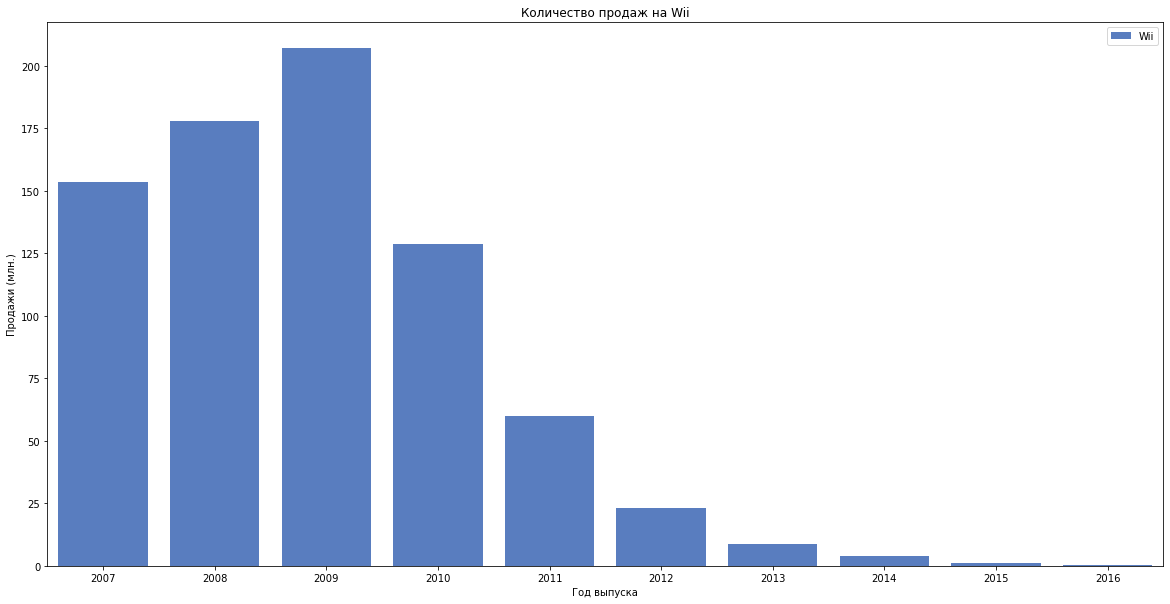

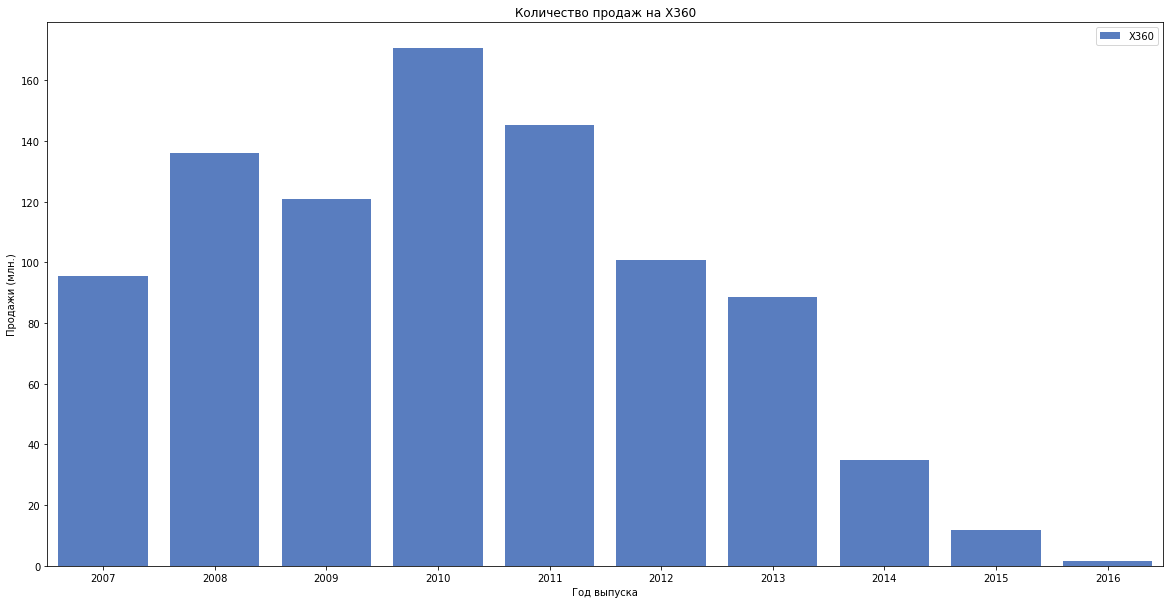

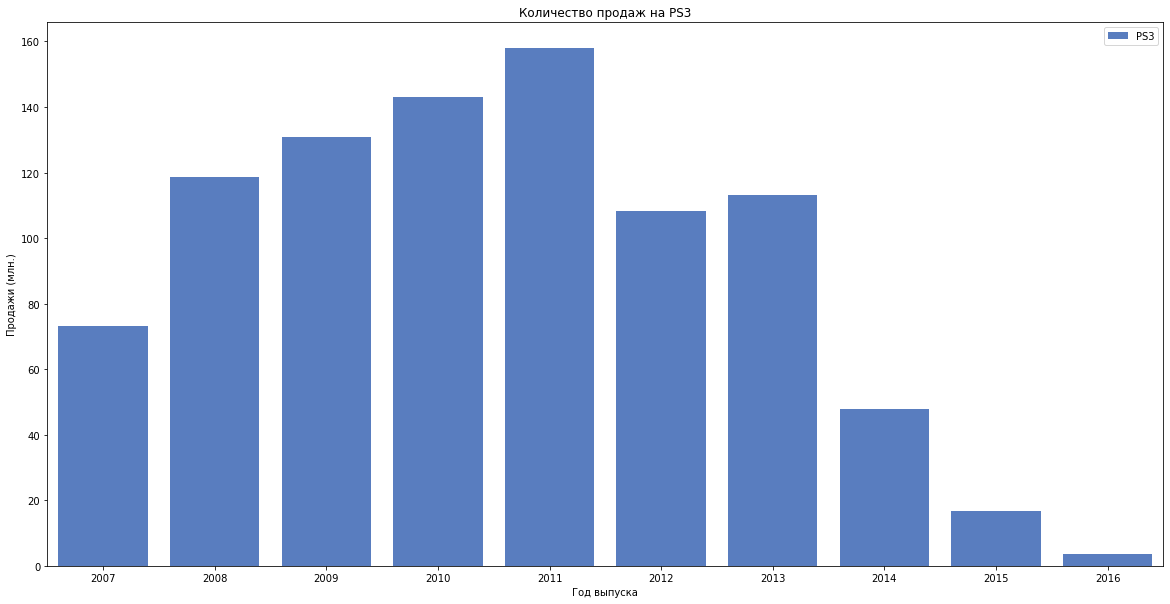

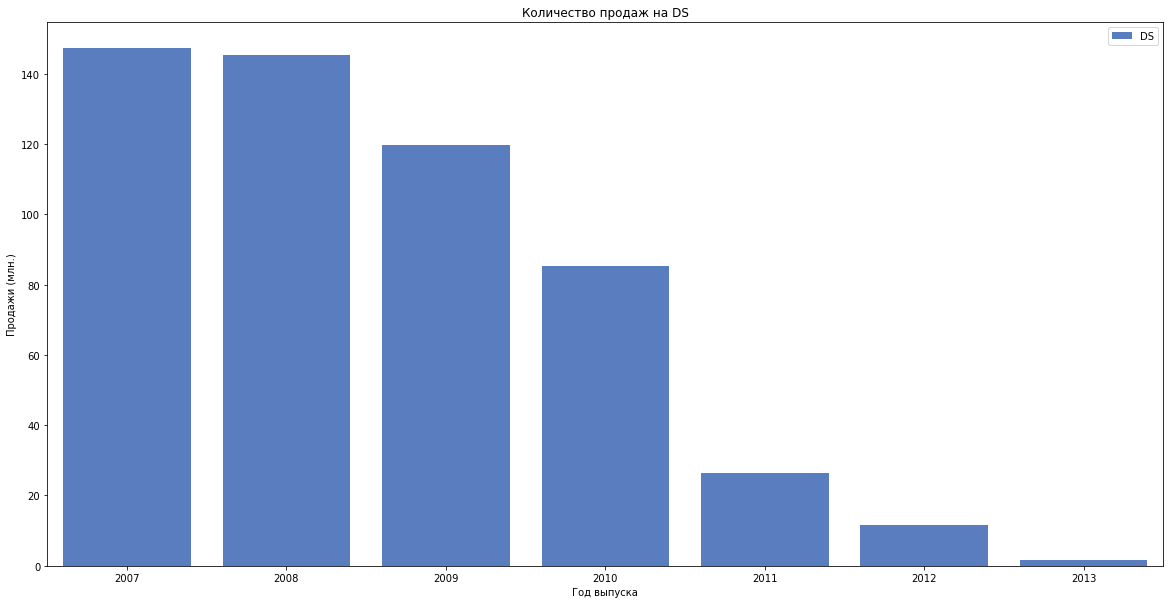

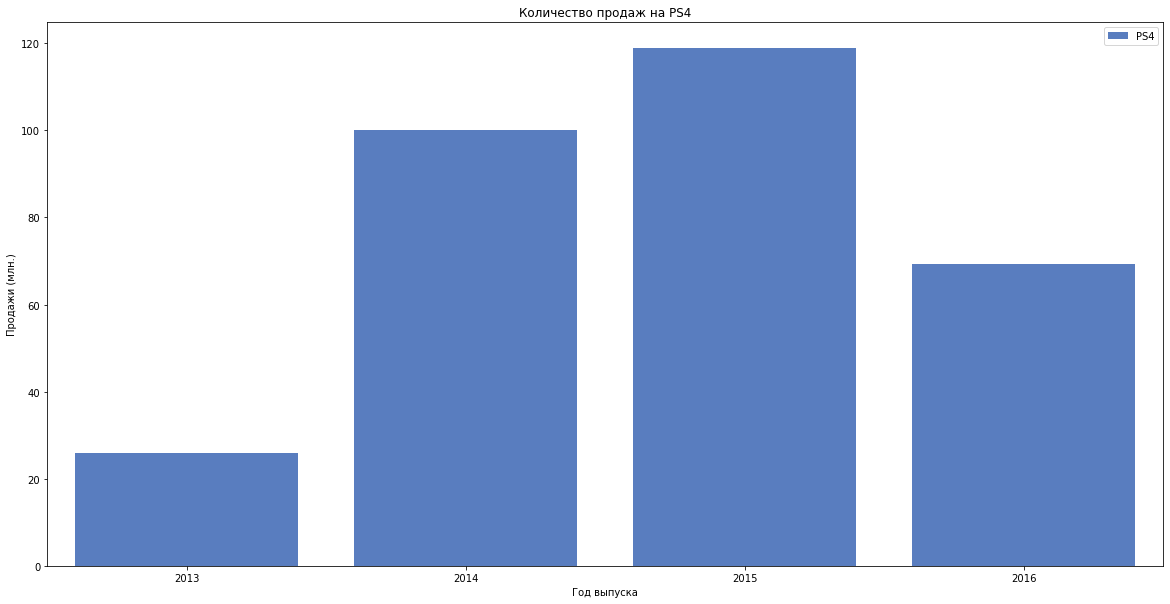

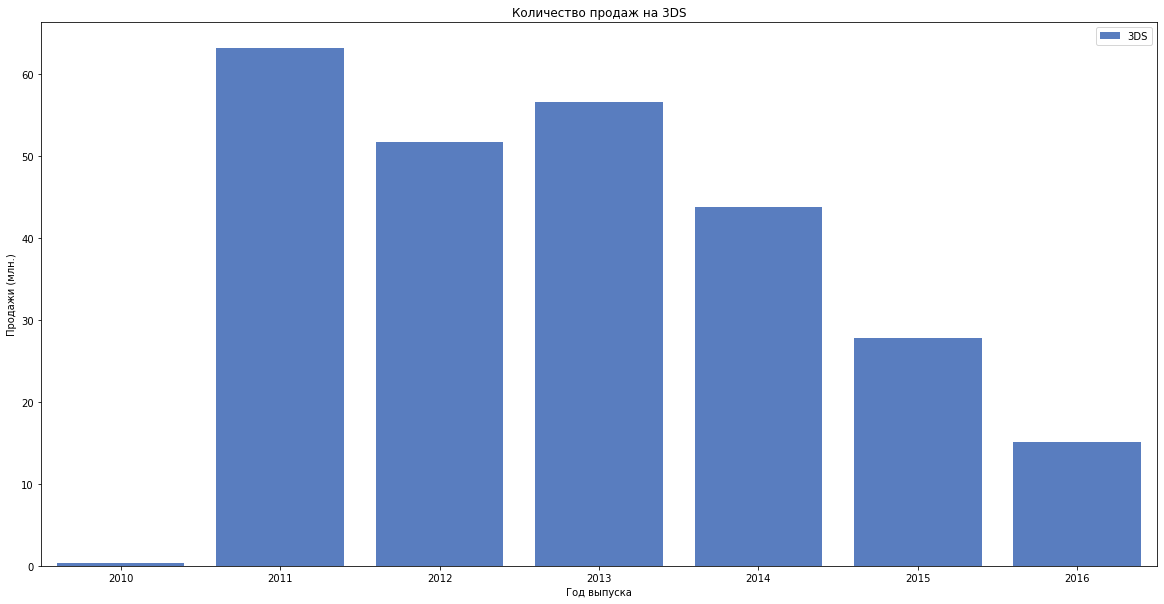

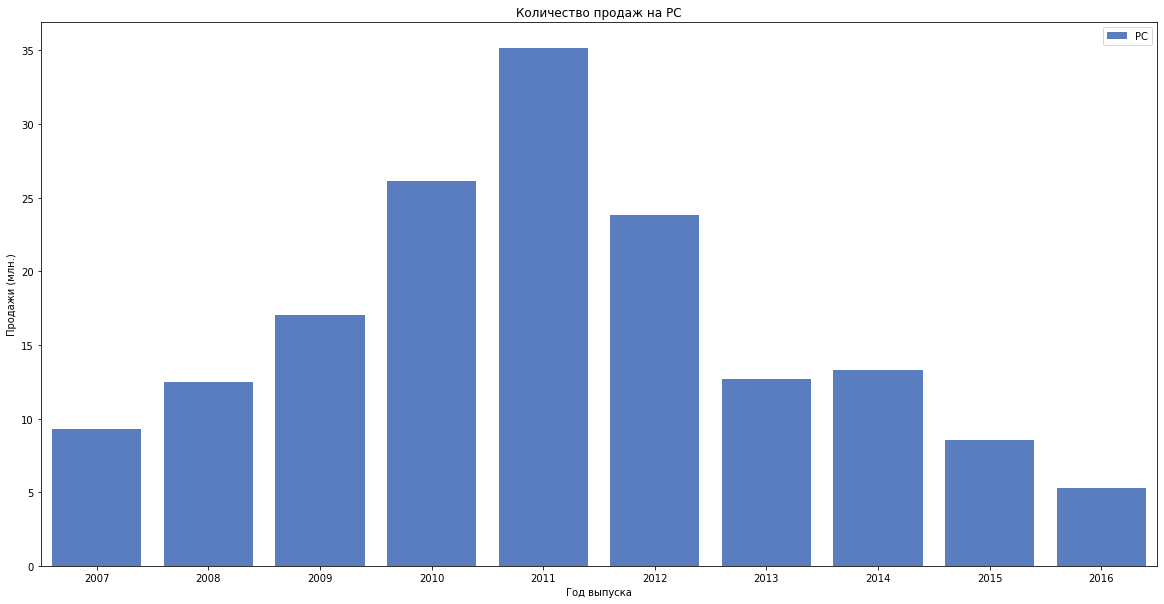

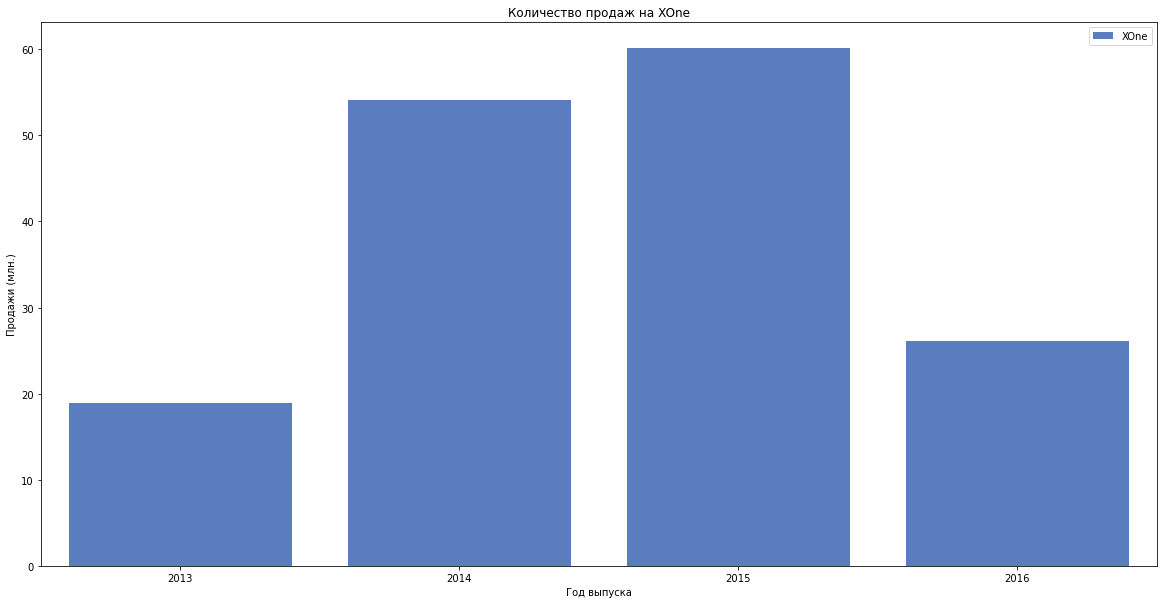

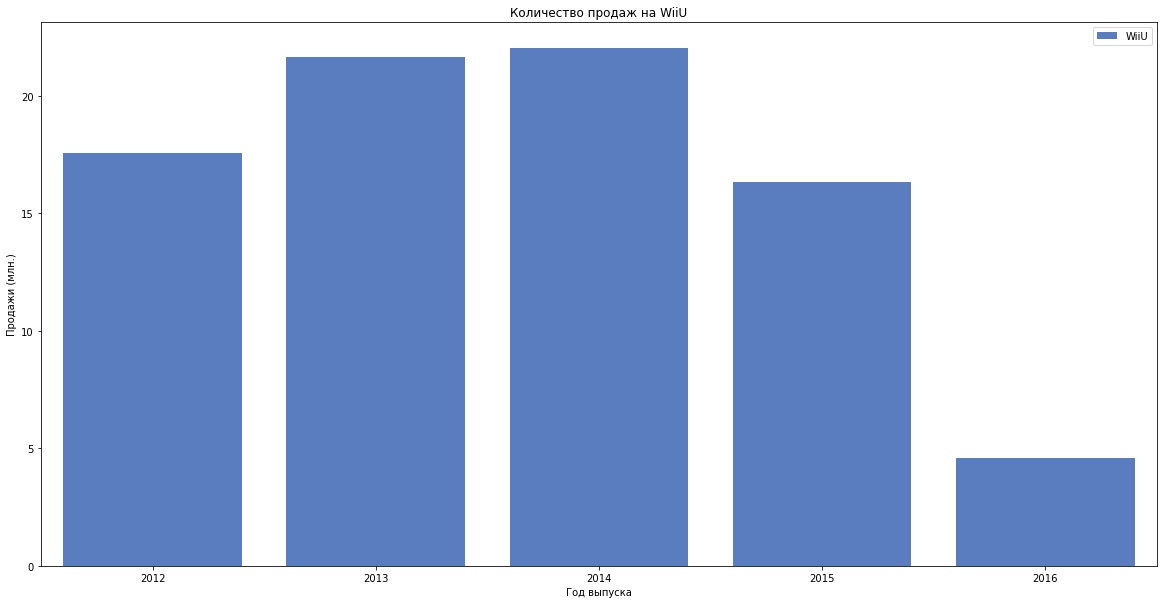

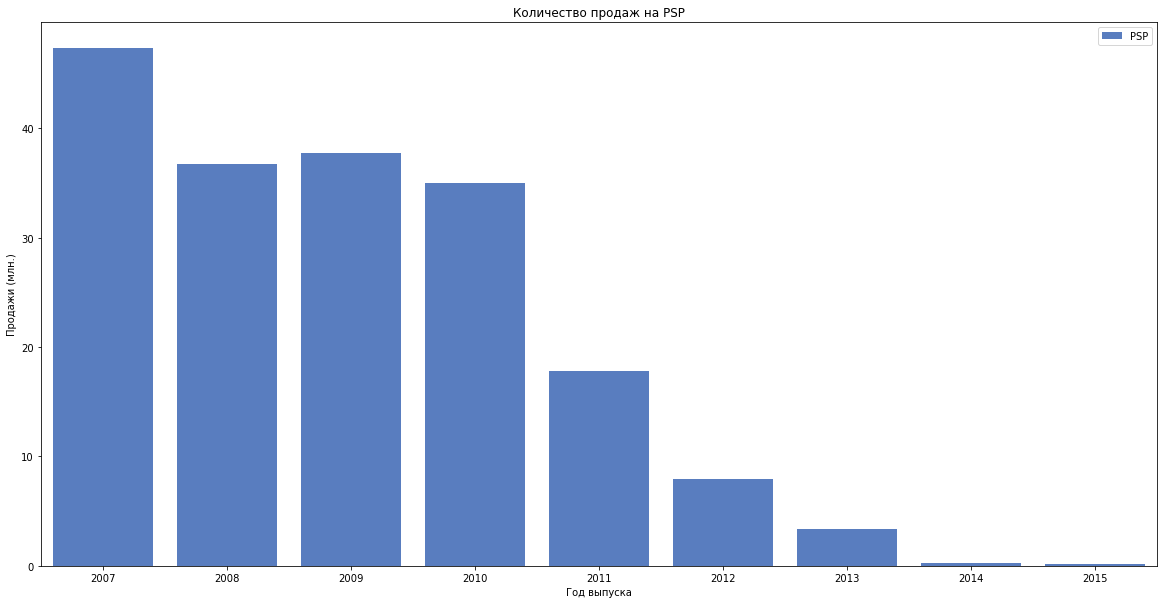

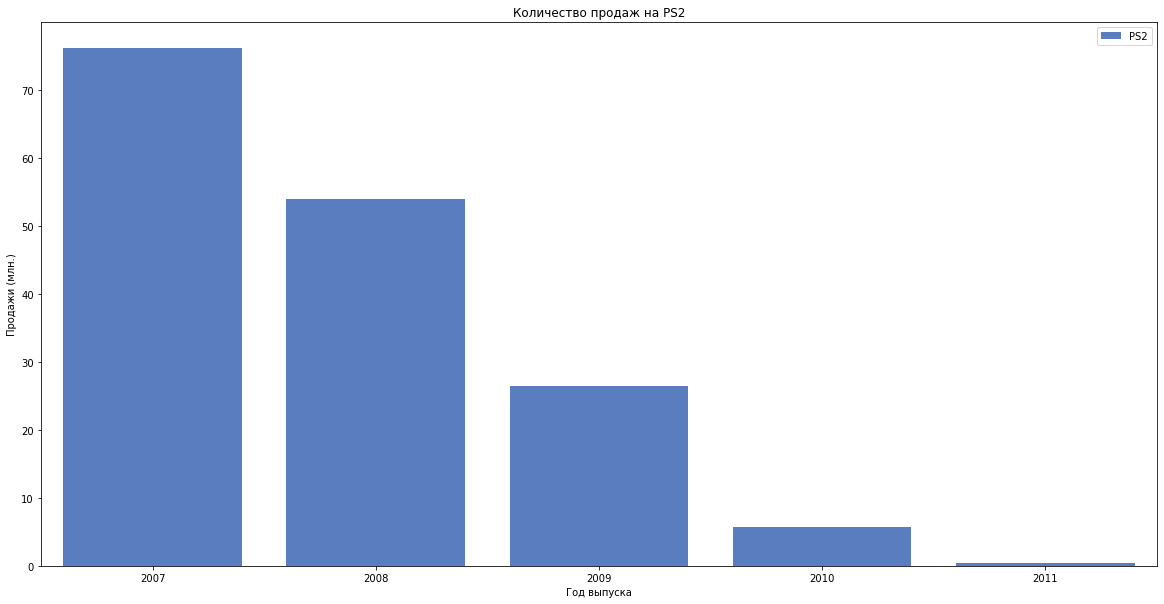

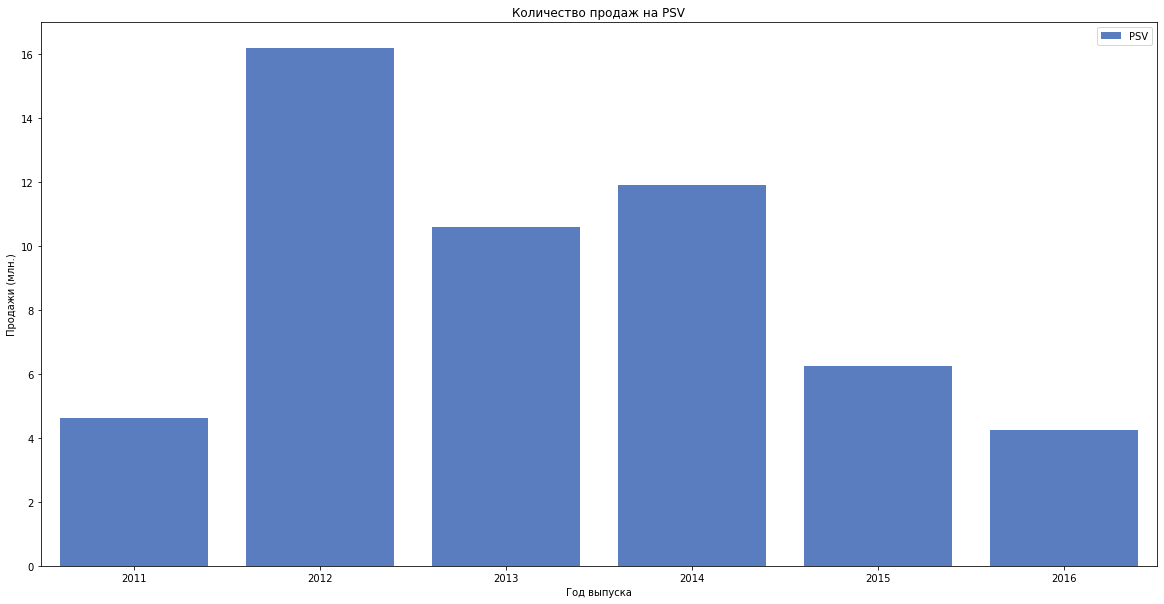

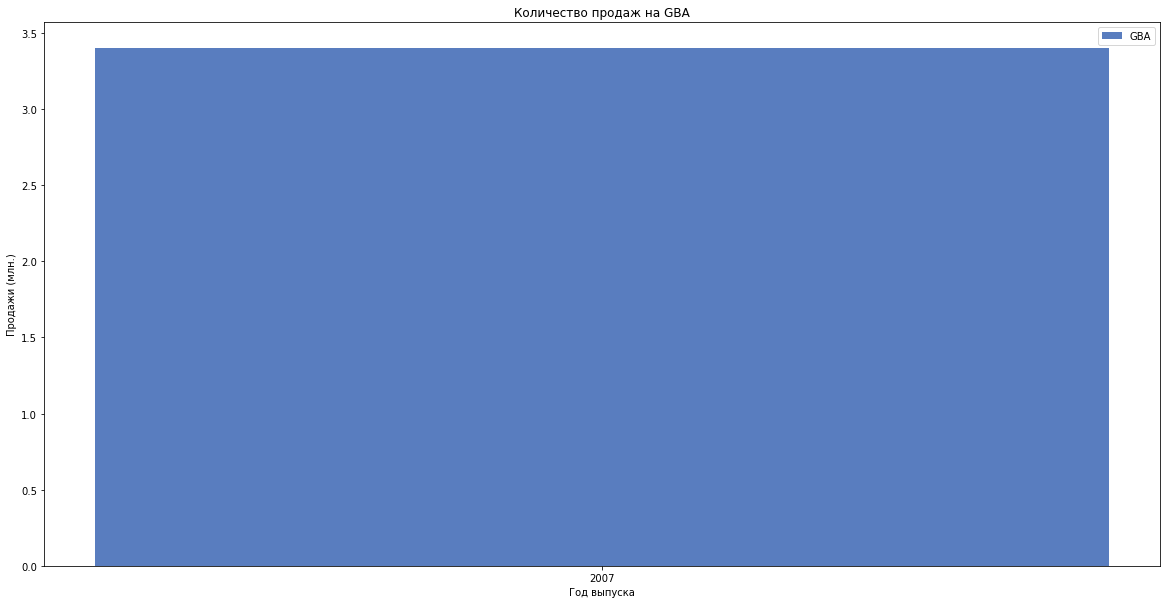

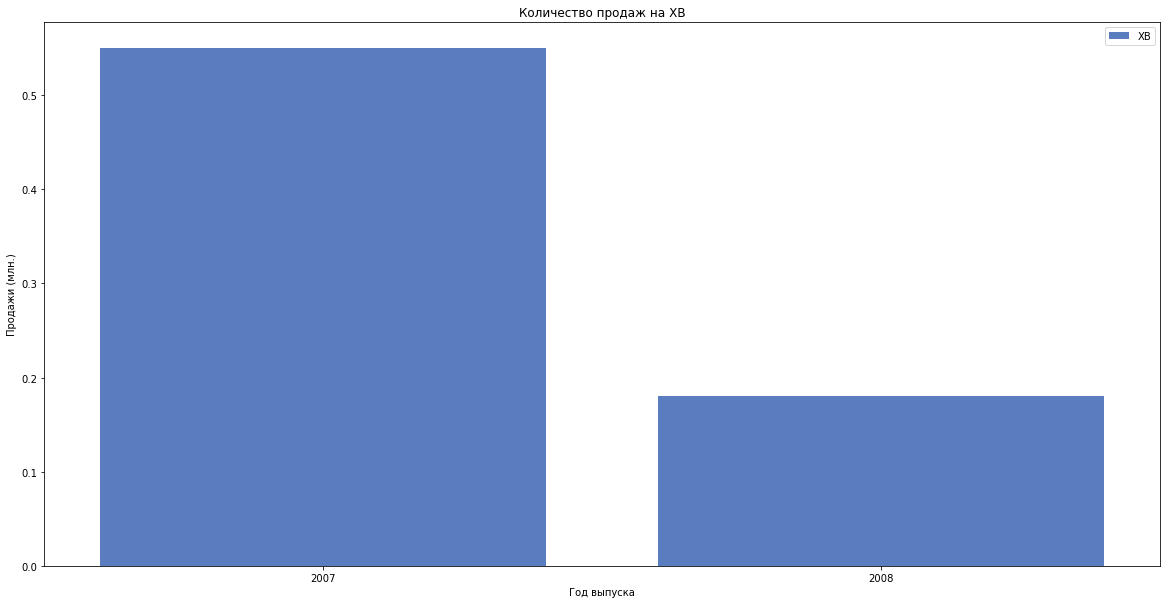

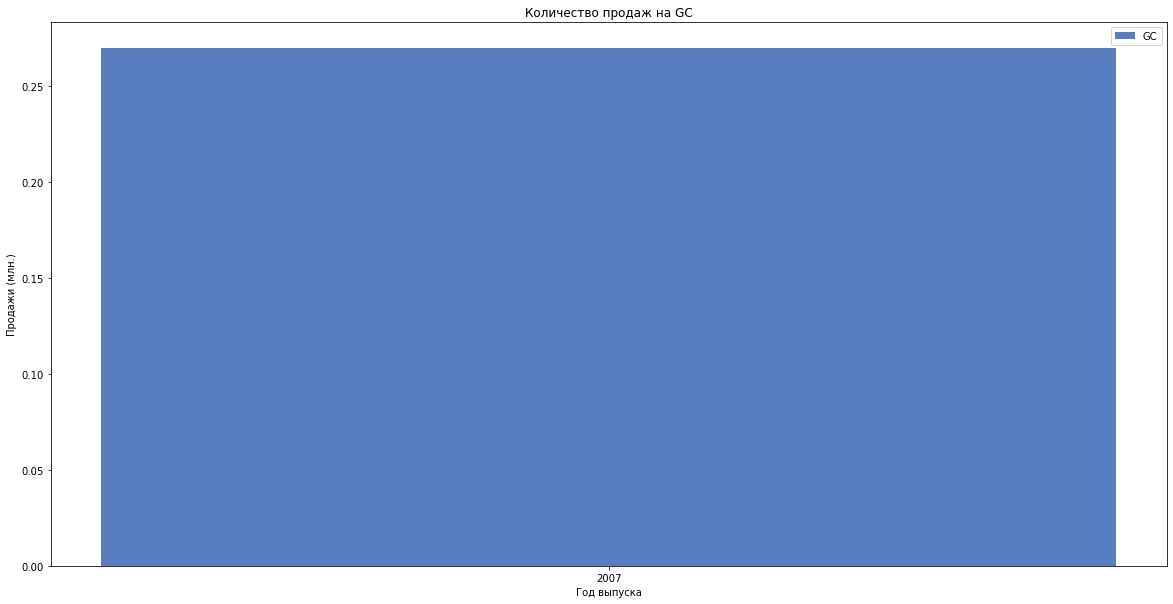

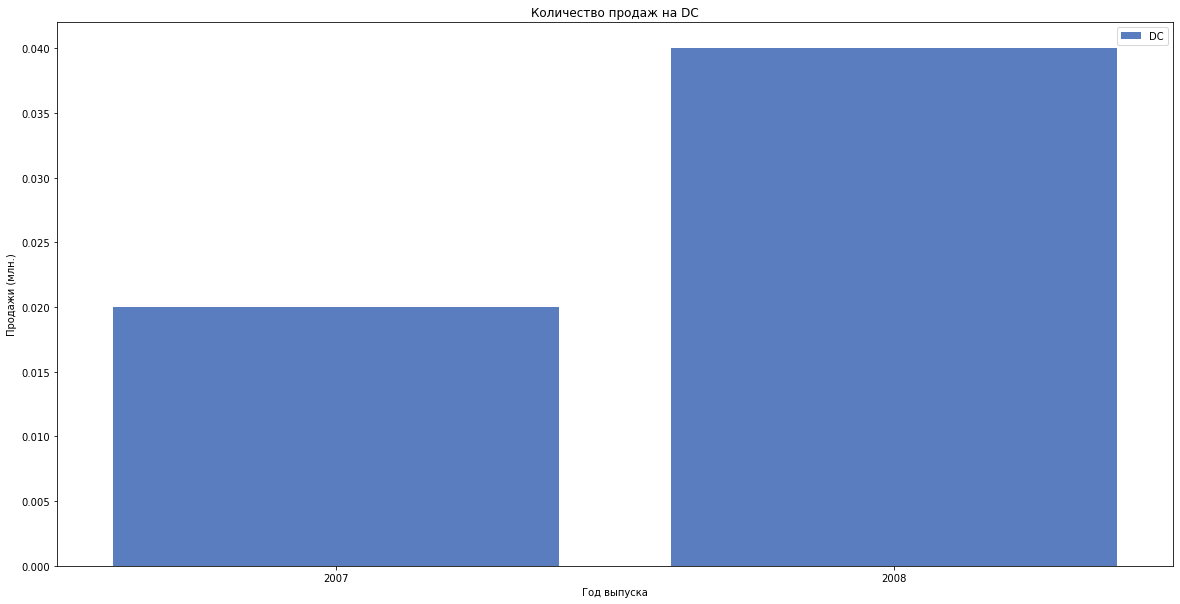

In [44]:
#Сгруппируем по платформам и посмотрим на распредение продаж по годам для различных платформ
grouped_by_popular_platform=data_for_forecast.pivot_table(index=['platform','year_of_release'],
                                                          values='all_sales',
                                                          aggfunc='sum')
interesting_platform=data_for_forecast['platform'].unique()
grouped_by_popular_platform.reset_index(inplace=True)
for i in range(len(interesting_platform)):
    f,ax=plt.subplots(figsize=(20,10))
    platform=interesting_platform[i]
    data_local=grouped_by_popular_platform.query('platform==@platform')
    sns.barplot(x='year_of_release', y='all_sales', data=data_local, 
                label=platform, color='b')
    
    ax.legend(loc="best", frameon=True)
    
    ax.set(ylabel='Продажи (млн.)',
       xlabel="Год выпуска",
      title='Количество продаж на '+ interesting_platform[i])
    
    plt.show()

In [45]:
#Суммарные продажи на 2016 год
grouped_by_popular_platform.query('year_of_release==2016').sort_values(by='all_sales')

,platform,year_of_release,all_sales
71,Wii,2016,0.18
86,X360,2016,1.52
42,PS3,2016,3.60
61,PSV,2016,4.25
76,WiiU,2016,4.60
27,PC,2016,5.25
6,3DS,2016,15.14
92,XOne,2016,26.15
46,PS4,2016,69.25


In [46]:
#Суммарные продажи на 2007 год
grouped_by_popular_platform.query('year_of_release==2007')

,platform,year_of_release,all_sales
7,DC,2007,0.02
9,DS,2007,147.24
16,GBA,2007,3.40
17,GC,2007,0.27
18,PC,2007,9.28
28,PS2,2007,76.10
33,PS3,2007,73.19
47,PSP,2007,47.34
62,Wii,2007,153.41
77,X360,2007,95.41


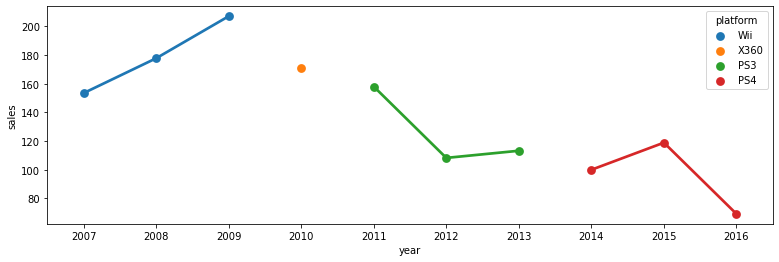

In [47]:
#Самыме популярные платформы в различные годы
most_popular_platform=pd.DataFrame(columns=['year','platform', 'sales'])

for year in grouped_by_popular_platform.sort_values(by='year_of_release')['year_of_release'].unique():
    local_data=grouped_by_popular_platform.query('year_of_release==@year')
    max_sales=0
    popular_platform=""
    for i in range(len(local_data)):
        sales=local_data.iloc[i,2]
        platform=local_data.iloc[i,0]
        if sales>max_sales:
            max_sales=sales
            popular_platform=platform
    
    row={}
    row['year'] = year
    row['platform'] = popular_platform
    row['sales'] = max_sales
    most_popular_platform = most_popular_platform.append(row, ignore_index=True)
    
plt.figure(figsize=(13, 4))
sns.pointplot(x = most_popular_platform['year'] ,
              y = most_popular_platform.sales , 
              hue = most_popular_platform.platform);

In [48]:
#Просто так
most_popular_game=data_for_forecast.groupby('name').sum().sort_values('all_sales',
                                                                      ascending=False)['all_sales'].head(100).index

In [49]:
#Сгруппируем по имени игры и платформе
grouped_by_name_and_platform=data_for_forecast.pivot_table(index=['platform', 'name'], 
                                                           values=['all_sales'], aggfunc='sum')
grouped_by_name_and_platform.reset_index(inplace=True)
grouped_by_name_and_platform

,platform,name,all_sales
0,3DS,Beyblade Burst,0.03
1,3DS,Fire Emblem Fates,1.67
2,3DS,Frozen: Olaf's Quest,0.59
3,3DS,Haikyu!! Cross Team Match!,0.04
4,3DS,12-Sai. Honto no Kimochi,0.07
...,...,...,...
9389,XOne,XCOM 2,0.04
9390,XOne,ZombiU,0.01
9391,XOne,Zombie Army Trilogy,0.11
9392,XOne,Zoo Tycoon (2013),0.36


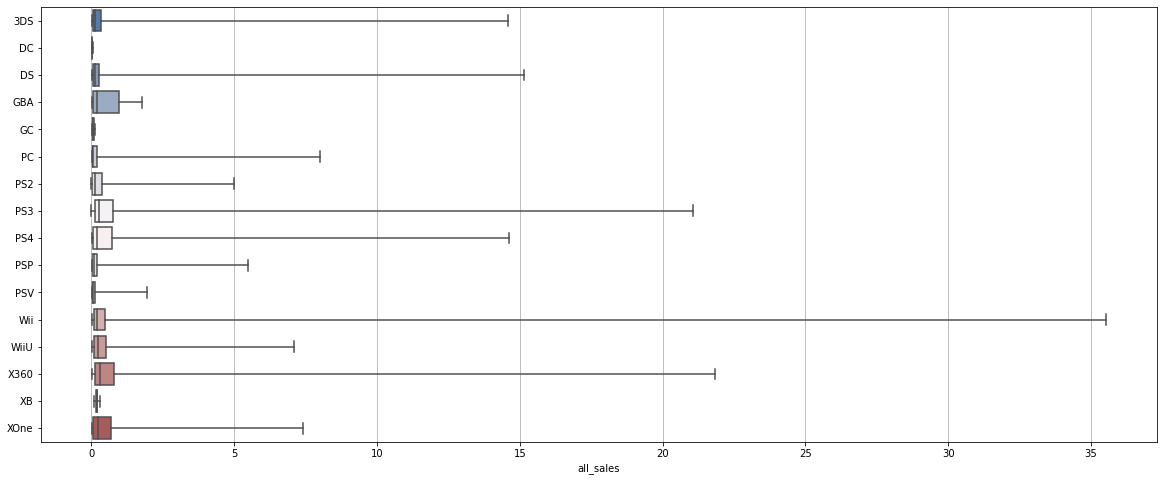

In [50]:
#Группируем по играм и платформам
f, ax = plt.subplots(figsize=(20, 8))
sns.boxplot(x="all_sales", y="platform", data=grouped_by_name_and_platform,
            whis=[0, 100], 
            palette="vlag")
ax.xaxis.grid(True)
ax.set(ylabel="")
plt.show()

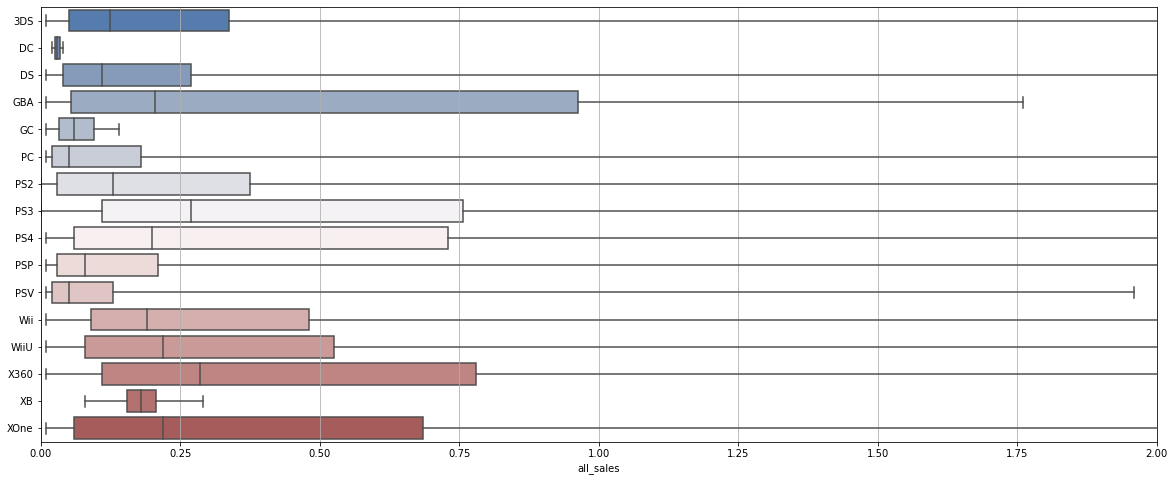

In [51]:
#Группируем по играм и платформам и смотрим на средние
f, ax = plt.subplots(figsize=(20, 8))
sns.boxplot(x="all_sales", y="platform", data=grouped_by_name_and_platform,
            whis=[0, 100], 
            palette="vlag")
ax.xaxis.grid(True)
ax.set(ylabel="", xlim=(0,2))
plt.show()

In [52]:
#Выделяем только PS4 и только  с отзывами
PS4_parse=data_for_forecast.query(
    'platform=="PS4" and critic_score>0 and user_score>0')[['critic_score',
                                                            'user_score',
                                                            'all_sales']]

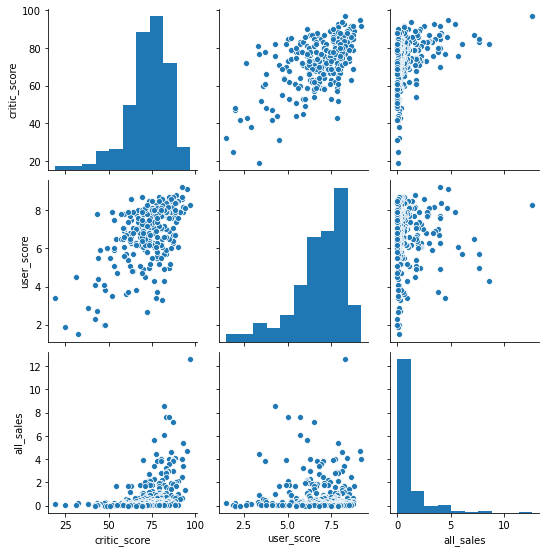

In [53]:
#Тут не очень видно
sns.pairplot(PS4_parse)

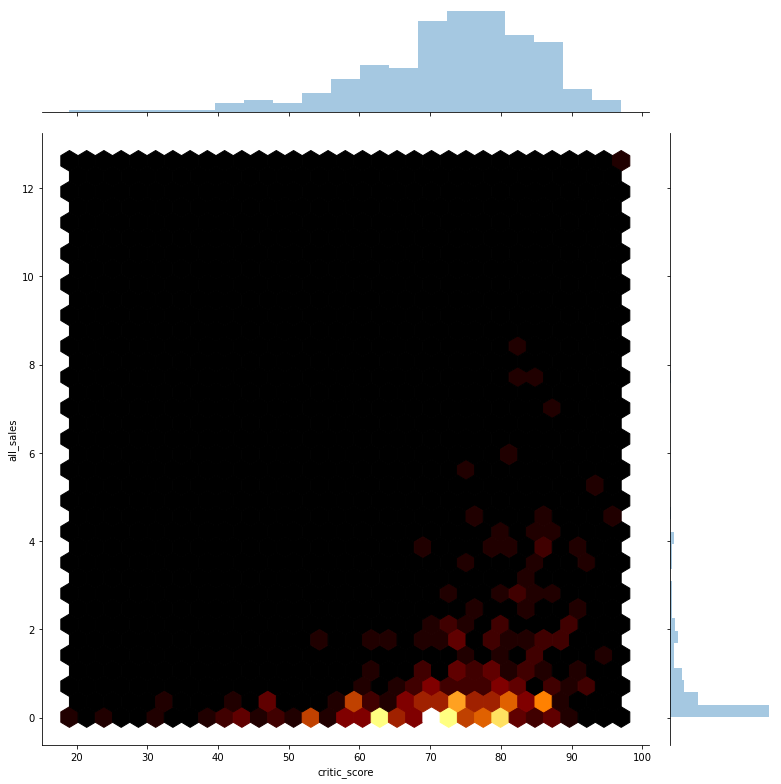

In [54]:
#Глянь поближе
sns.jointplot('critic_score','all_sales',data=PS4_parse,
              kind='hex', cmap='afmhot', height=11)

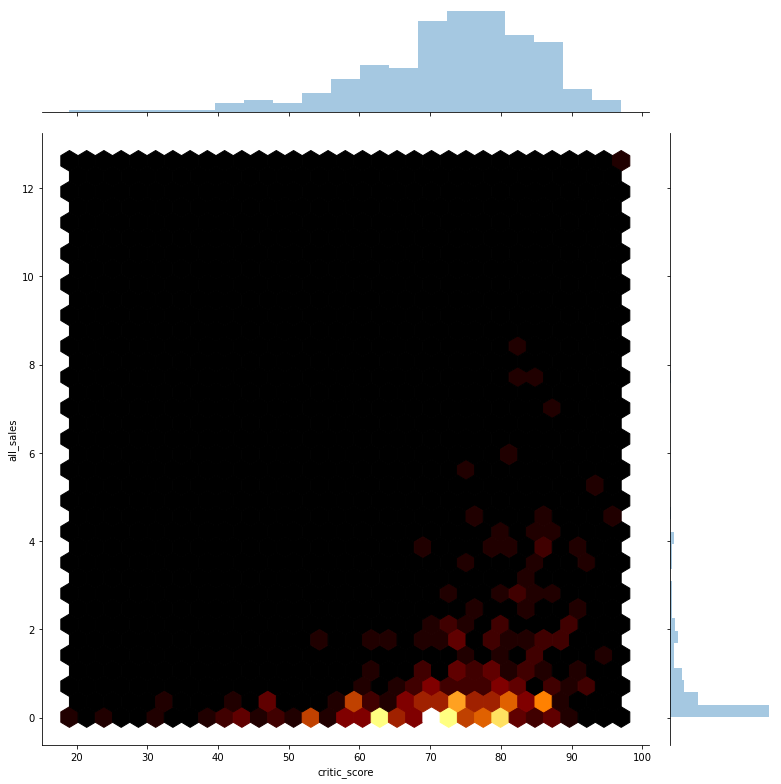

In [55]:
sns.jointplot('critic_score','all_sales',data=PS4_parse,
              kind='hex', cmap='afmhot', height=11)

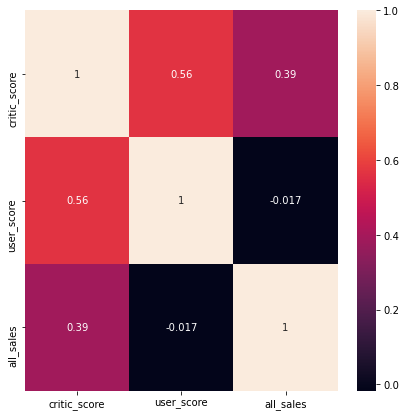

In [56]:
#корреляционная матрица
plt.figure(figsize=(7,7))
sns.heatmap(PS4_parse.corr(),
            annot=True
           )

In [57]:
#Посмотрим на продажи по всем годам для всех платформ
data_for_forecast.pivot_table(index='platform', values='all_sales', aggfunc='sum').sort_values(by='all_sales')

,all_sales
platform,
DC,0.06
GC,0.27
XB,0.73
GBA,3.40
PSV,53.81
WiiU,82.19
XOne,159.32
PS2,162.49
PC,163.61


In [58]:
#Сделаем тоже самое и для DS (портативка)
DS_parse=data_for_forecast.query(
    'platform=="DS" and critic_score>0 and user_score>0')[['critic_score',
                                                            'user_score',
                                                            'all_sales']]

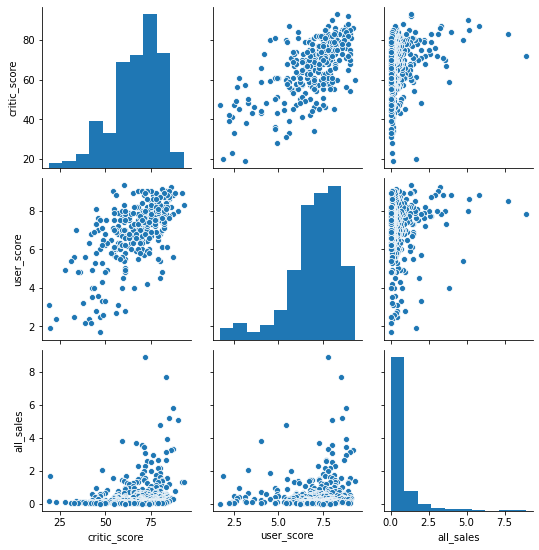

In [59]:
#Тут не очень видно
sns.pairplot(DS_parse)

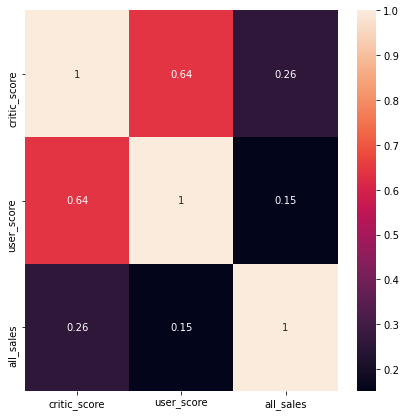

In [60]:
#корреляционная матрица
plt.figure(figsize=(7,7))
sns.heatmap(DS_parse.corr(),
            annot=True
           )

In [61]:
#Сгруппируем по жанру и годам
grouped_by_genre_and_year=data_for_forecast.pivot_table(index=['genre', 'year_of_release'], values='all_sales', aggfunc='sum')

In [62]:
#Сгруппируем по жанру
grouped_by_genre=data_for_forecast.pivot_table(index=['genre'], values='all_sales', aggfunc='sum')
grouped_by_genre.sort_values('all_sales')

,all_sales
genre,
Strategy,69.62
Puzzle,79.83
Adventure,130.01
Fighting,166.23
Simulation,199.46
Platform,230.45
Racing,265.32
Role-Playing,465.08
Misc,489.62


Text(0.5, 0, 'Год')

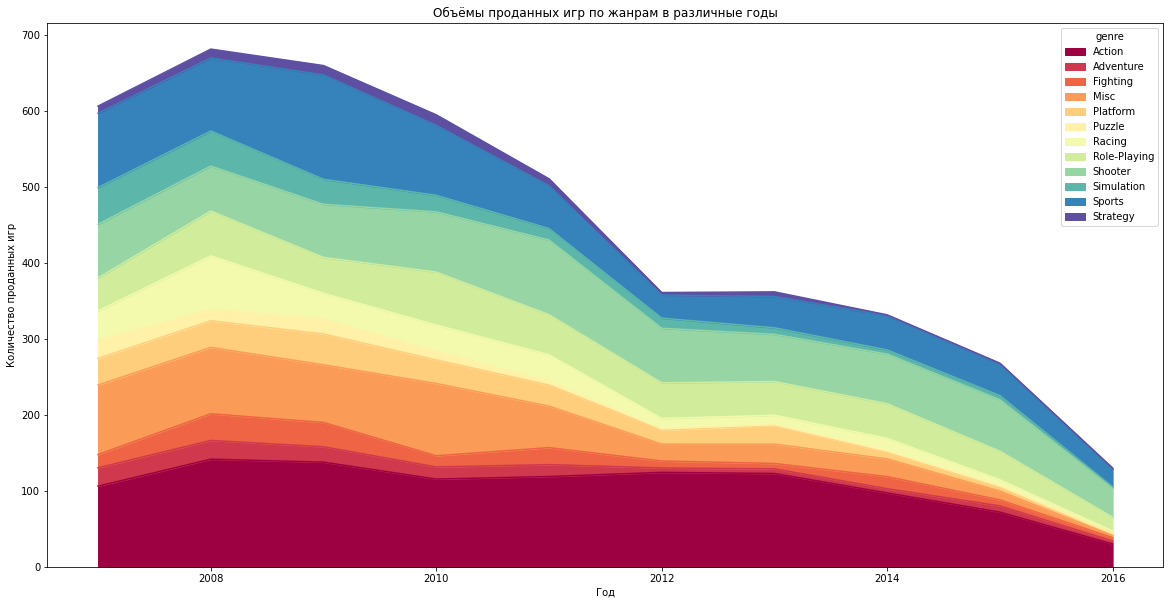

In [63]:
#Стековое распределение продаж по жанрам в различные годы
grouped_by_genre_and_year.unstack().T.loc['all_sales'].plot(kind='area', 
                                  figsize=(20,10),
                                  stacked=True,
                                  colormap= 'Spectral'
                                 )
plt.title("Объёмы проданных игр по жанрам в различные годы")
plt.ylabel('Количество проданных игр')
plt.xlabel('Год')

Text(0.5, 0, 'Год')

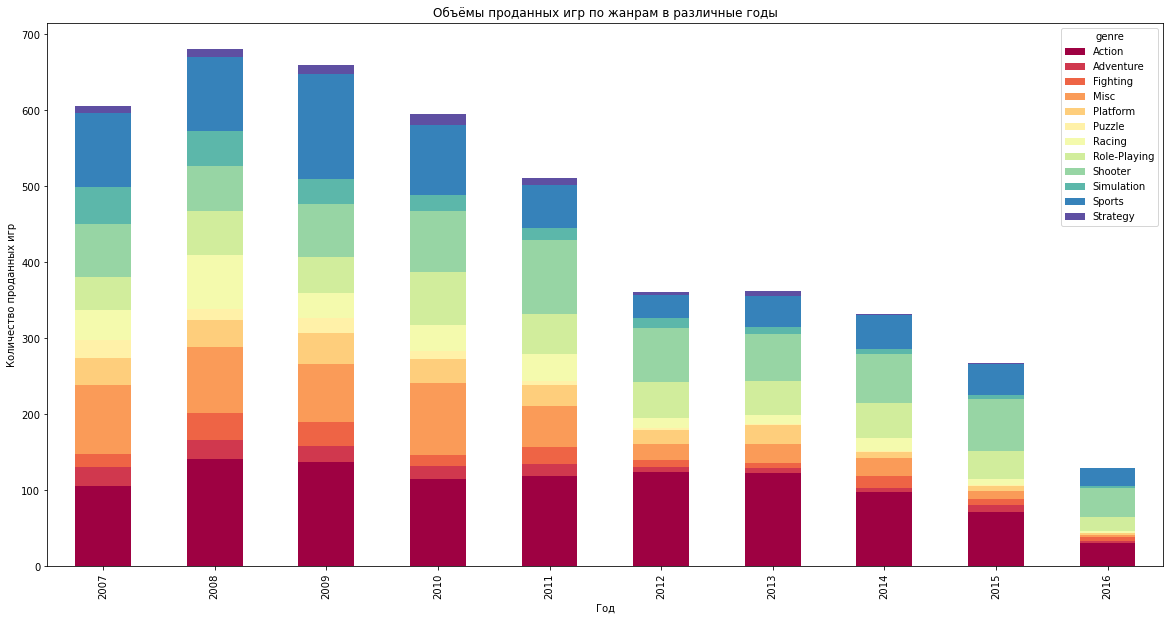

In [64]:
#Тоже самое, но в баре
grouped_by_genre_and_year.unstack().T.loc['all_sales'].plot(kind='bar', 
                                  figsize=(20,10),
                                  stacked=True,
                                  colormap= 'Spectral'
                                 )
plt.title("Объёмы проданных игр по жанрам в различные годы")
plt.ylabel('Количество проданных игр')
plt.xlabel('Год')

In [65]:
data_for_forecast.query('genre=="Shooter"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
9,Call of Duty: Modern Warfare 3,X360,2011,Shooter,9.04,4.24,0.13,1.32,88.0,3.4,M,14.73
10,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,-1.0,-1.0,NaN,14.63
11,Call of Duty: Black Ops,X360,2010,Shooter,9.70,3.68,0.11,1.13,87.0,6.3,M,14.62
13,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79
14,Call of Duty: Black Ops II,X360,2012,Shooter,8.25,4.24,0.07,1.12,83.0,4.8,M,13.68
...,...,...,...,...,...,...,...,...,...,...,...,...
9250,Clive Barker's Jericho,PC,2007,Shooter,0.00,0.01,0.00,0.00,63.0,7.5,M,0.01
9251,Bullet Soul: Tama Tamashii,X360,2011,Shooter,0.00,0.00,0.01,0.00,-1.0,-1.0,NaN,0.01
9283,DoDonPachi Daifukkatsu: Black Label,X360,2011,Shooter,0.00,0.00,0.01,0.00,-1.0,-1.0,NaN,0.01
9305,"Transformers: War for Cybertron (XBox 360, PS3...",PC,2010,Shooter,0.01,0.00,0.00,0.00,-1.0,-1.0,NaN,0.01


**Вывод**:
При анализе объёма игр по годам (по суммарным тиражам и по количеству уникальных игр) видно, что наиболее продуктивным с точки зрения игроделов можно считать 2008-2010 год. Именно в эти годы индустрия выпускает наибольшее количество игр в год и имеет максимальные продажи.
Для анализа продаж по платформам будем анализировать только топ 10 платформ по продажам как видно из графика и анализа продолжительности жизни платформы через 3 сигма, медианное время жизни платформы - 10 лет. Медиана использована потому, что есть компьютеры не являются платформой, которая в текущих реалиях может устареть, а также среди фаворитов по количеству продаж есть PS4, которая только начинает свой жизненный цикл в качестве игровой платформы (по крайней мере на 2016 год она именно этим и занималась)
Исходя из того, что медианное время жизни платформы является 11 лет, то для предсказания на 2017 год необходимо использовать период с 2007 по 2016 
Таким образом для анализа у нас есть более 9к данных

Следующие платформы на 2016 год окончательно упали: Xbox360, wii, DS,PS3, 
Растут продажи следующих платформ: PS4
Платформа nintendo 3ds является специфичной платформой (это портативная консоль) и время жизни у неё короче, пик продаж был в 2015, но они до сих пор полузуются популярностью
Продажи XboxONE были на пике в 2015 и сейчас идут на спад, но в 2017 они будут ещё актуальны
А интетрес пользователей к ПК хоть и небольшой, но не падает как у консолей
Портотивные консоли PSP, PS vita и WiiU также прошли уже нахоядстся на закате жизненного цикла или продажи по ним совсем отсуствуют, но при этом игры для PSV в 2017 будут ещё актуальный. Эра портативных консолей подошла к концу
Продажи на PS2 в 2017 неоправданы.
остальные консоли также неактуальны
Таким образом лидирующие поизицию занимают PS4, 3DS, Xbox One, PC и WiiU

Как видно из boxplot, продажи игр на всех платформах имеют почти одинаковое распределение. Есть парочка игр, которые продаются с максимальным тиражём и именно поэтому платформа держит свои лидирующие позиции. Но если посмотреть на средние значения, то видно, что большинство игр продаются в среднем в количестве 250_000 копий назависимо от консоли и почти в 2 раза мень для портативных консолей.

Так как самая популярная платформа - это PS4 - то следующий анализ будет строиться для этой платформы. Нас интересуют столбцы critic_score, user_score, all_sales и только те записи, в которых присутствуют отзывы. Для анализа у нас имеется 282 строки. Как видно из корреляционной матрицы, зависимости между отзывами пользователей и объёмом продаж нет (почти 0), возможно покупатель сам не знает чего хочет. Однако критики в большей степени понимают, когда игра будет продаваемой, однако и их рецензии не сшиком коррелируют с продажами (0.39). Однако между отзывами критиков и пользователей корреляция есть. Возможно, пользователи формируют мнение об игре под влиянием оценки критиков, что ещё больше смещяет оценку в сторону субъективности небольшой группы пользователей (критиков). Аналогичная ситуация наблюдается и для портотивных консолей. Оценки критиков и пользователей никак не влияют на продажи игры. Предполагаю, что аналогичные рассуждения можно провести и для других платформ.

Во все времена люди больше всего любят поиграть в Action игры (вроде GTA, Batman, Assassin's Creed). До 2011 года люди любили поиграть в музыкальные игры, там где надо двигаться в ритм музыке и аналогичные, но потом интерес к этой категории игр угас. Со спортивными играми аналогичная ситуация. Шутеры же в свою очередь неизменно пользуются интересом у пользователей (ты ведь и сам(а) любишь на doomguy поотправлять врагов обратно в присподню). Интерес к остальным категориям играм с годами только уменьшается.

# Шаг 4. Составьте портрет пользователя каждого региона

In [66]:
#Самые популярные платформы (топ-5). Опишите различия в долях продаж.
places=['na_sales', 'eu_sales', 'jp_sales', 'other_sales']
place_name=['Северной Америке', 'Европе', 'Японии', 'других странах']
for_visualize=pd.DataFrame()
for place in places:
    print('Топ 5 платформ в', place_name[places.index(place)],':')
    data_local=data_for_forecast.groupby('platform')[place].sum().sort_values().sort_values(ascending=False)
    result=data_local[:5]/data_local.sum()*100
    print(result)
    for_visualize=pd.merge(for_visualize, result, how='outer', left_index=True, right_index=True)
    print('='*20, end='\n\n')


Топ 5 платформ в Северной Америке :
platform
X360    26.024032
Wii     19.710922
PS3     17.909917
DS      12.870004
PS4      5.088108
Name: na_sales, dtype: float64

Топ 5 платформ в Европе :
platform
PS3     23.321562
X360    18.777429
Wii     15.768594
PS4     10.251548
DS       8.735868
Name: eu_sales, dtype: float64

Топ 5 платформ в Японии :
platform
DS     21.050802
3DS    20.578370
PS3    16.040167
PSP    13.649378
Wii    12.250491
Name: jp_sales, dtype: float64

Топ 5 платформ в других странах :
platform
PS3     26.179992
X360    15.980953
Wii     12.940567
PS2     10.852543
PS4      9.633201
Name: other_sales, dtype: float64



In [67]:
#Заполним пропуски нулями
for_visualize.fillna(0, inplace=True)

In [68]:
#Взглянем на получившуюся таблицу
for_visualize

,na_sales,eu_sales,jp_sales,other_sales
platform,,,,
3DS,0.000000,0.000000,20.578370,0.000000
DS,12.870004,8.735868,21.050802,0.000000
PS2,0.000000,0.000000,0.000000,10.852543
PS3,17.909917,23.321562,16.040167,26.179992
PS4,5.088108,10.251548,0.000000,9.633201
PSP,0.000000,0.000000,13.649378,0.000000
Wii,19.710922,15.768594,12.250491,12.940567
X360,26.024032,18.777429,0.000000,15.980953


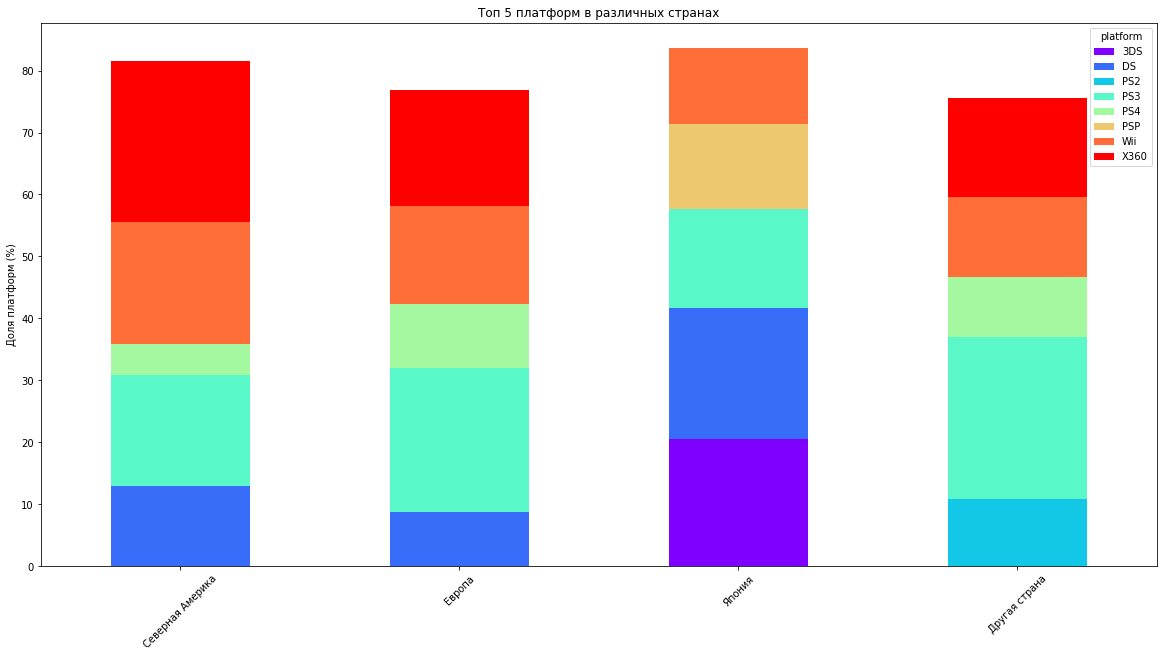

In [69]:
#Визуализируем эту статистику
for_visualize.T.plot(kind='bar', 
                    figsize=(20,10),
                    stacked=True,
                    colormap= 'rainbow')


plt.title('Топ 5 платформ в различных странах')
plt.ylabel('Доля платформ (%)')
locs, _=plt.xticks()
plt.xticks(locs,['Северная Америка', 'Европа', 'Япония', 'Другая страна'], rotation=45)
#plt.xticks(for_visualize.index, ['Северная Америка', 'Европе', 'Японии', 'других странах'], rotation='vertical')
plt.show()

In [70]:
#Самые популярные жанры
places=['na_sales', 'eu_sales', 'jp_sales', 'other_sales']
place_name=['Северной Америке', 'Европе', 'Японии', 'других странах']
for_visualize=pd.DataFrame()
for place in places:
    print('Топ 5 жанров в', place_name[places.index(place)],':')
    data_local=data_for_forecast.groupby('genre')[place].sum().sort_values().sort_values(ascending=False)
    result=data_local[:5]/data_local.sum()*100
    print(result)
    for_visualize=pd.merge(for_visualize, result, how='outer', left_index=True, right_index=True)
    print('='*20, end='\n\n')


Топ 5 жанров в Северной Америке :
genre
Action          23.409791
Shooter         16.441132
Sports          15.212387
Misc            12.152222
Role-Playing     8.207698
Name: na_sales, dtype: float64

Топ 5 жанров в Европе :
genre
Action     24.792193
Shooter    16.819978
Sports     15.427093
Misc        9.280088
Racing      7.607464
Name: eu_sales, dtype: float64

Топ 5 жанров в Японии :
genre
Role-Playing    30.800065
Action          19.694863
Misc            10.186927
Sports           8.291067
Adventure        5.503518
Name: jp_sales, dtype: float64

Топ 5 жанров в других странах :
genre
Action          25.564344
Sports          16.496982
Shooter         16.226017
Misc            10.436134
Role-Playing     7.252296
Name: other_sales, dtype: float64



In [71]:
for_visualize

,na_sales,eu_sales,jp_sales,other_sales
genre,,,,
Action,23.409791,24.792193,19.694863,25.564344
Adventure,NaN,NaN,5.503518,NaN
Misc,12.152222,9.280088,10.186927,10.436134
Racing,NaN,7.607464,NaN,NaN
Role-Playing,8.207698,NaN,30.800065,7.252296
Shooter,16.441132,16.819978,NaN,16.226017
Sports,15.212387,15.427093,8.291067,16.496982


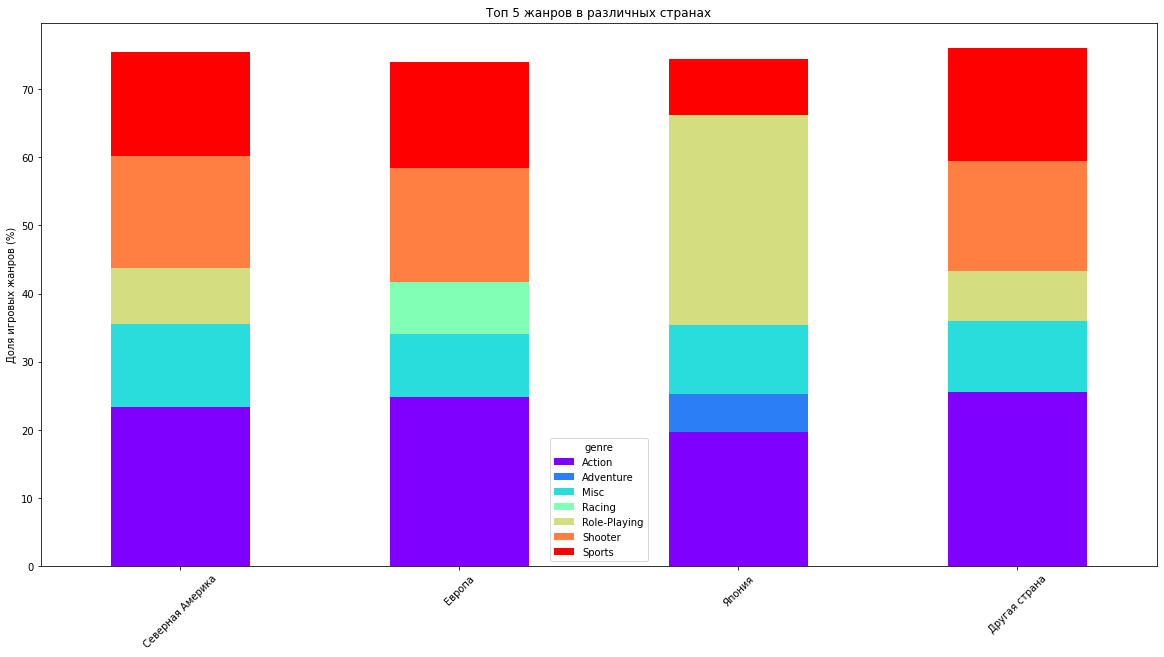

In [72]:
#Визуализируем эту статистику
for_visualize.T.plot(kind='bar', 
                    figsize=(20,10),
                    stacked=True,
                    colormap= 'rainbow')


plt.title('Топ 5 жанров в различных странах')
plt.ylabel('Доля игровых жанров (%)')
locs, _=plt.xticks()
plt.xticks(locs,['Северная Америка', 'Европа', 'Япония', 'Другая страна'], rotation=45)
#plt.xticks(for_visualize.index, ['Северная Америка', 'Европе', 'Японии', 'других странах'], rotation='vertical')
plt.show()

In [73]:
#Влияет ли рейтинг ESRB на продажи в отдельном регионе?
group_by_reting=data_for_forecast[~data_for_forecast.rating.isnull()].pivot_table(index='rating', 
                                                                                  values=places, 
                                                                                  aggfunc='sum')
common_sums=group_by_reting.sum()

In [74]:
group_by_reting=group_by_reting/common_sums*100

In [75]:
group_by_reting

,eu_sales,jp_sales,na_sales,other_sales
rating,,,,
E,33.706267,39.141892,35.361047,32.139133
E10+,14.313984,13.139257,15.622178,14.705814
EC,0.000000,0.000000,0.070117,0.018539
M,33.265943,16.931566,29.150952,31.277084
RP,0.002570,0.000000,0.000000,0.002317
T,18.711236,30.787285,19.795706,21.857113


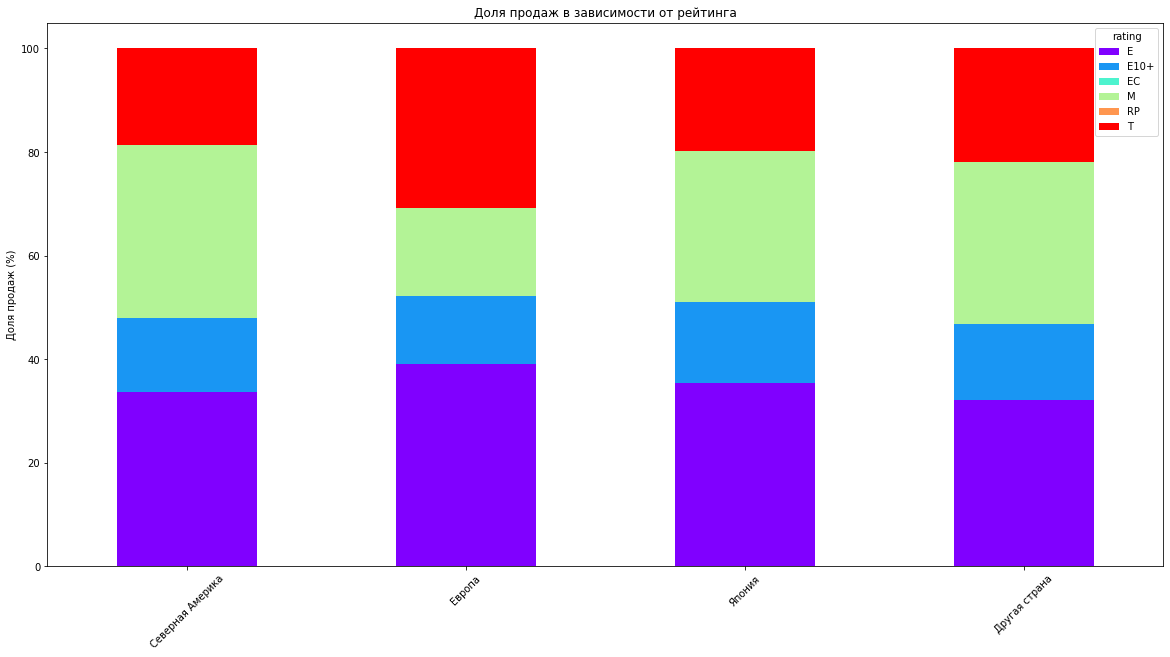

In [76]:
#Визуализируем эту статистику
group_by_reting.T.plot(kind='bar', 
                    figsize=(20,10),
                    stacked=True,
                    colormap= 'rainbow')


plt.title('Доля продаж в зависимости от рейтинга')
plt.ylabel('Доля продаж (%)')
locs, _=plt.xticks()
plt.xticks(locs,['Северная Америка', 'Европа', 'Япония', 'Другая страна'], rotation=45)
#plt.xticks(for_visualize.index, ['Северная Америка', 'Европе', 'Японии', 'других странах'], rotation='vertical')
plt.show()

In [77]:
#Корреляция между рейтингом и объёмами продаж
#введём числвоые обозеначения для категорий
for_parsing=data_for_forecast[~data_for_forecast.rating.isnull()]

In [78]:
def set_rating_num(row):
    if row['rating']=="E":
        return 0
    if row['rating']=="E10+":
        return 1
    if row['rating']=="EC":
        return 2
    if row['rating']=="M":
        return 3
    if row['rating']=="RP":
        return 4
    if row['rating']=="T":
        return 5
    return -1

In [79]:
for_parsing['rating_num']=for_parsing.apply(set_rating_num, axis=1)

c:\users\ilka\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [80]:
for_parsing.corr()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,all_sales,rating_num
year_of_release,1.000000,-0.029928,0.054168,0.008090,-0.003520,0.174817,0.153686,0.005148,0.118431
na_sales,-0.029928,1.000000,0.797851,0.443001,0.763528,0.213264,0.164967,0.946430,-0.005153
eu_sales,0.054168,0.797851,1.000000,0.479341,0.838511,0.243299,0.184357,0.931918,0.005230
jp_sales,0.008090,0.443001,0.479341,1.000000,0.404385,0.142191,0.149972,0.583930,0.012606
other_sales,-0.003520,0.763528,0.838511,0.404385,1.000000,0.247109,0.191207,0.866129,0.024959
critic_score,0.174817,0.213264,0.243299,0.142191,0.247109,1.000000,0.686630,0.245245,0.256009
user_score,0.153686,0.164967,0.184357,0.149972,0.191207,0.686630,1.000000,0.193854,0.338518
all_sales,0.005148,0.946430,0.931918,0.583930,0.866129,0.245245,0.193854,1.000000,0.004130
rating_num,0.118431,-0.005153,0.005230,0.012606,0.024959,0.256009,0.338518,0.004130,1.000000


**Вывод**:
Как видно из графика, люди в северной америке и в европе используют одинаковые платформы, но они лишь немного отличаются в процентном соотношении (В америке предпочитают Xbox360, а в европе PS3). Ситуация в остальном мире аналогична европе и америке, за тем лишь исключением, что вместо портативной консоли DS геймеры предпочитают PS2. 
Люди во всём мире (кроме японии) отдают предпочтение стационарным консолям перед портативными
В японии ситуация несколько иная. Там люди предпочитают играть на 3DS и DS игнорируя при этом Xbox 360 (может он там запрещён как и PS4). Ещё одним доказательством что японцы предпочитают портативные консоли заключается в том, что только у геймеров популярны PSP.

Во всех странах люди любят поиграть в Action, музыкальные игры и в спортивные игры (японцы чуть меньше чем остальной мир любит игры в жанре sports). В японии люди очень редко играют в шутеры, отдавая предпочтение играм в жанре Adventure Role-Playing. Люди в европе вместо Role-Playing выбирают racing. В категорию Action игр преимущественно попадают самые топовые игры, поэтому неудивительно что данный жанр нравится людям из всех стран. Игры в стиле RPG больше всего приглянулись японцам, а вот в европе пользователи к ним равнодушны. Это объясняется тем, что RPG чаще выходят на консолях и, как было показано на графиках выше, именно в японии преобладают портативные консоли.

Различий в продажах игр в различных регионах практически нет. Только в японии игры для тинейджеров покупаются чаще, чем игры для врослых. Корреляции между рейтингом игры и суммарными продажами в регионе не обнаружено

# Шаг 5. Проверьте гипотезы

In [81]:
#Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
alpha = .05 # критический уровень статистической значимости

XboxOne=data_for_forecast.query('platform=="XOne"')['user_score']
PC=data_for_forecast.query('platform=="PC"')['user_score']

results = st.ttest_ind(
    XboxOne, 
    PC)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Средние пользовательские рейтинги платформ Xbox One и PC разный")
else:
    print("Средние пользовательские рейтинги платформ Xbox One и PC одинаковый")

p-значение: 0.7033057325546352
Средние пользовательские рейтинги платформ Xbox One и PC одинаковый


In [82]:
#Средние пользовательские рейтинги жанров Action  и Sports  разные.
alpha = .05 # критический уровень статистической значимости

Action=data_for_forecast.query('genre=="Action"')['user_score']
Sports=data_for_forecast.query('genre=="Sports"')['user_score']

results = st.ttest_ind(
    Action, 
    Sports)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Средние пользовательские рейтинги жанров Action  и Sports  разные.")
else:
    print("Средние пользовательские рейтинги жанров Action  и Sports  одинаковые.")

p-значение: 1.0969326840998563e-07
Средние пользовательские рейтинги жанров Action  и Sports  разные.


**Вывод**:
При формировании нулевых гипотез мы исходим из следующего утверждения: Пользовательские рейтингы равны.
Выборки являются независимыми, так как у нас нет рейтингов, которыю используют игры с 2 жанрами или с 2 платформами. Для проверки гипотез мы использовали стандартный t-тест (потому что другой мы не изучали) и получили следующие значения p-value:<br>
1) исходя из того, что мы получили p-value равным 0.7 следует, что пользователиськие рейтинги для Xbox One и PC. т.е. есть если ли проведём аналогичные исследования для другой выборки из генеральной совокупности (например только за период 2013-2014 год), то мы получим такие или более выраженные доказательства что выборки (оценки пользователей будут одинаковы) одинаковы<br>
2) Ввиду того, что p-value получилось почти равным 0, то можно предположить, что пользователи выбирают или игры жанры Action или игры в жанре Sports и вероятность получить такие ищё более выраженные различия составляет почти 0%. 

# Шаг 6. Напишите общий вывод

**Вывод**:
Исходные данные представляют собой двумерную таблицу в 16715 и 11 признаками (столбцами). 
При первоначальном анализе было обнаружено больше количество пропусков в столбцах с рейнигом, 
годом издания игры и оценками критиков и пользователей. В работе используются различные подходы к заполнению
недостающих значений с целью включению в выборку для анализа как можно большего количества релевантной информации
В качестве дополнения стоит  отметить, что одним из способов заполнения пропусков можно было бы  использовать 
модуль requests для считывания веб-странницы по конкретной игре для конкртеной плафтормы с какого-нибудь популярного
сайта с оценками игр, например с metacritic.com, и использовать любой парсер web страниц, например beautifulsoup,  
для заполнения пропусков, чтобы ещё больше повысить точность исследования, особенно для игр до 2007 года.
Для заполнения пропусков использовалась средние значения, сгруппированные по играм, так как одни и  теже игры выходят 
на несколько платформ и заполнение пропусков медианами является допустимым решением, так как ни год реализации, 
ни оценки критоков существенно не отличаются у одноимённых игр. Для заполнения года реализация также использовались
регулярные выражения для вычлинения года выпуска игры из её наименования. Как правило игра выходит на год раньше, чем указано в её имени
В различные года на рынке доминировали различные платформы, но набольшие продажи за всё время показала PS2. Как 
было выяснено из анализа распределения продаж игр на различных платформах по годам, медианное время жизни  платформы 
составляет 10 лет, однако из графиков видно, что портативные консоли живут меньше (примерно в 2 раза). В различные
годы пользователей захватывали различные платформы, но в период с 2007 по 2016 пользователей в большей степени интересовали
Wii (2007-2009), Xbox 360 (2010), PS3 (2011-2013), PS4(2014-2016). При анализе продаж на различные платформы было выяснено, что хоть
разброс значений у различных платформ и сильно отличается (игровые индустрии выпускают хиты для отдельных платформ)
средние значения для всех платформ почти одинаковые: 250 тыс для стационарных консолей и 125 тыс для портативных и ПК
При анализе корреляции между оценками и продажами было выяснено, оценки пользователей вообще не коррелируют  с продажами,
а оценки критиков лишь на 0.39, что также является недостаточным, чтобы можно было утверждать, что между этими показателями
есть зависимость. Из года в год самыми популярными жанрами остаются игры в жанрах Actioon, Shooter и RPG.
Портрет пользователей для различных регионов имеет преимущественно одинаковый вид для всего мира. Однако в Японии люди 
склонны играть на портативных консолях и поэтому для них характерным жанром игр является RPG и именно японцы предпочитают игры для Teen в большей 
степени, чем в остальном мире. При оценке гипотез было выяснено, что оценки пользователей для платформ Xbox One и PC одинаковы, но при этом 
оценки для разных игровых жанров у пользователей отличаются

# TODO

- [x] откройте файл с данными;
- [x] изучите общую информацию;
- [x] замените названия столбцов (приведите к нижнему регистру);
- [x] опишите, в каких столбцах заменили тип данных и почему;
- [x] обработаны пропуски;
  - [x] объяснено почему заполнены пропуски определённым образом или почему не делал этого;
  - [x] объяснены возможные причины, которые могли привести к пропускам;
  - [x] обработана аббревиатура tbd в столбце с рейтингом
- [x] преобразуйте данные в нужные типы;
- [x] посчитаны суммарные продажи во всех регионах. Результат записан в отдельный столбец
- [x] посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?
- [x] посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?
- [x] возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год. Не учитывайте в работе данные за предыдущие годы.
- [x] какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.
- [x] постройте график «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам. Велика ли разница в продажах? А в средних продажах на разных платформах? Опишите результат.
- [x] посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.
- [x] Соотнесите выводы с продажами игр на других платформах.
- [x] Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?
- [] Определите для пользователя каждого региона (NA, EU, JP):
  - [x] Самые популярные платформы (топ-5). Опишите различия в долях продаж.
  - [x] Самые популярные жанры (топ-5). Поясните разницу.
  - [x] Влияет ли рейтинг ESRB на продажи в отдельном регионе?
- [x] Проверьте гипотезы
  - [x] Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
  - [x] Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.
  - [x] Как вы сформулировали нулевую и альтернативную гипотезы;
  - [x] Какой критерий применили для проверки гипотез и почему.
- [x] Напишите общий вывод

# Критерии оценки

- Как вы описываете выявленные в данных проблемы?
- Как готовите датасет к анализу?
- Какие строите графики для распределений и как их объясняете?
- Как рассчитываете стандартное отклонение и дисперсию?
- Формулируете ли альтернативную и нулевую гипотезы?
- Какие методы применяете, чтобы их проверить?
- Объясняете результат проверки гипотезы или нет?
- Соблюдаете ли структуру проекта и поддерживаете аккуратность кода?
- Какие выводы делаете?
- Оставляете ли комментарии к шагам?